# Copied from "fast_and_slow_rotators_analysis_011023.ipynb"
# 1/13/23 - Looking at oblate and prolate with delta_pa and uncertainties, first with obvious rotators and then experimenting with Anowar's procedure using probabilities.
# 1/23/23 - Looking at the new measurements from the b-spline models

In [1]:
################################################################

# import general libraries and modules
import numpy as np
np.set_printoptions(threshold=10000)
import matplotlib.pyplot as plt
import matplotlib.colors as colors
plt.rcParams["figure.figsize"] = (8, 6)
plt.rcParams.update({'font.size': 14})
import pandas as pd
import warnings
warnings.filterwarnings( "ignore", module = "matplotlib\..*" )
warnings.filterwarnings( "ignore", module = "plotbin\..*" )
from os import path
import glob
#import Image from PIL
from PIL import Image
import pickle

# astronomy/scipy
from astropy.io import fits
from astropy.wcs import WCS
from scipy.ndimage import rotate
from scipy.ndimage import map_coordinates
from scipy.optimize import least_squares as lsq
from astropy.convolution import convolve, convolve_fft, Gaussian2DKernel
from astropy.cosmology import Planck15 as cosmo  # Originally I did Planck 2018, but it seems this one isn't in the version of astropy we have on here and I'm not 
from scipy.interpolate import interp1d
from scipy.optimize import fsolve

# mge fit
import mgefit
from mgefit.find_galaxy import find_galaxy
from mgefit.mge_fit_1d import mge_fit_1d
from mgefit.sectors_photometry import sectors_photometry
from mgefit.mge_fit_sectors import mge_fit_sectors
from mgefit.mge_print_contours import mge_print_contours
from mgefit.mge_fit_sectors_regularized import mge_fit_sectors_regularized


# jam
from jampy.jam_axi_proj import jam_axi_proj
from jampy.jam_axi_proj import rotate_points
from jampy.jam_axi_proj import bilinear_interpolate
from jampy.mge_half_light_isophote import mge_half_light_isophote
from plotbin.plot_velfield import plot_velfield
from plotbin.sauron_colormap import register_sauron_colormap
register_sauron_colormap()
from pafit.fit_kinematic_pa import fit_kinematic_pa

# my functions
import sys
sys.path.append("/home/shawnknabel/Documents/slacs_kinematics/my_python_packages")
from slacs_mge_jampy import crop_center_image
from slacs_mge_jampy import import_center_crop
from slacs_mge_jampy import try_fractions_for_find_galaxy
from slacs_mge_jampy import convert_mge_model_outputs
from slacs_mge_jampy import plot_contours_321
from slacs_mge_jampy import load_2d_kinematics
from slacs_mge_jampy import bin_velocity_maps
from slacs_mge_jampy import rotate_bins
from slacs_mge_jampy import osipkov_merritt_model
from slacs_mge_jampy import find_half_light
from slacs_mge_jampy import calculate_minlevel
from slacs_mge_jampy import fit_kcwi_sigma_psf
from slacs_mge_jampy import optimize_sigma_psf_fit
from slacs_mge_jampy import estimate_hst_psf

################################################################
# some needed information
kcwi_scale = 0.147  # arcsec/pixel
hst_scale = 0.050 # ACS/WFC
# B band (F435W) dust extinction ~ 0.116 from https://irsa.ipac.caltech.edu/applications/DUST/
extinction = 0.116
### photometric zeropoint for F435W as of 2007 was 25.745
photometric_zeropoint = 25.745
# redshift, convert to angular diameter dist in Mpc
z = 0.195
distance = cosmo.angular_diameter_distance(z).value
# data directory
data_dir = '/data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/'
#################################################
# objects
obj_names = ['SDSSJ0029-0055',
             'SDSSJ0037-0942',
             'SDSSJ0330-0020',
             'SDSSJ1112+0826',
             'SDSSJ1204+0358',
             'SDSSJ1250+0523',
             'SDSSJ1306+0600',
             'SDSSJ1402+6321',
             'SDSSJ1531-0105',
             'SDSSJ1538+5817',
             'SDSSJ1621+3931',
             'SDSSJ1627-0053',
             'SDSSJ1630+4520',
             'SDSSJ2303+1422'
            ]

# Bring in SLACS data from table.

In [2]:
slacs_data = np.genfromtxt(f'{data_dir}slacs_tableA1.txt', delimiter='', dtype='U10')
slacs_zs = slacs_data[:,3].astype(float)
slacs_qs = slacs_data[:,9].astype(float)
slacs_reffs_ = slacs_data[:,7].astype(float)
slacs_pa_phots = slacs_data[:,10].astype(float)
slacs_morphologies = slacs_data[:,15].astype(str)
slacs_sigmas = slacs_data[:,11].astype(float)
slacs_sigmas_err = slacs_data[:,12].astype(float)

zs = np.empty(len(obj_names))
slacs_ellipticities = np.empty(len(obj_names))
slacs_reffs = np.empty(len(obj_names))
slacs_PA_phots = np.empty(len(obj_names))
morphologies = np.empty(len(obj_names), dtype=str)
sdss_sigmas = np.empty(len(obj_names))
sdss_sigmas_err = np.empty(len(obj_names))

for i in range(len(obj_names)):
    name = obj_names[i]
    name = name[4:]
    if name == 'J1306+0600':
        zs[i] = 0.0650 # Slacs XIII Shu 2017
        slacs_ellipticities[i] = 1 - 0.909 # These values from Shajib 2020
        slacs_reffs[i] = 2.30
        slacs_PA_phot = 0
        morphologies[i] = ''
        sdss_sigmas[i] = 0
        sdss_sigmas_err[i] = 0
    else:
        zs[i] = slacs_zs[slacs_data[:,0]==name]
        q = slacs_qs[slacs_data[:,0]==name]
        slacs_ellipticities[i] = 1 - q[0]
        slacs_reffs[i] = slacs_reffs_[slacs_data[:,0]==name]
        slacs_PA_phots[i] = slacs_pa_phots[slacs_data[:,0]==name]
        morphologies[i] = slacs_morphologies[slacs_data[:,0]==name][0]
        sdss_sigmas[i] = slacs_sigmas[slacs_data[:,0]==name]
        sdss_sigmas_err[i] = slacs_sigmas_err[slacs_data[:,0]==name]

# Look specifically at the effective radius

In [3]:
print(slacs_reffs)

[2.16 2.19 1.2  1.5  1.47 1.81 2.3  2.7  2.5  1.58 2.14 1.98 1.96 3.28]


In [4]:
print(zs)

[0.227  0.1955 0.3507 0.273  0.1644 0.2318 0.065  0.2046 0.1596 0.1428
 0.2449 0.2076 0.2479 0.1553]


In [5]:
# Plugging this in from my JAM notebook so that I can get the effective radius that I measured instead of using the SLACS one

# class to collect and save all the attributes I need for jampy
class jampy_details:
    
    def __init__(details, surf_density, mge_sigma, q, kcwi_sigmapst, Vrms_bin, dVrms_bin, V_bin, dV_bin, xbin_phot, ybin_phot, reff):
        details.surf_density=surf_density 
        details.mge_sigma=mge_sigma
        details.q=q 
        details.kcwi_sigmapst=kcwi_sigmapst 
        details.Vrms_bin=Vrms_bin 
        details.dVrms_bind=Vrms_bin
        details.V_bin=V_bin 
        details.dV_bin=dV_bin 
        details.xbin_phot=xbin_phot 
        details.ybin_phot=ybin_phot
        details.reff=reff

import pickle
def prepare_to_jam(obj_name, file_dir):

    # take the surface density, etc from mge saved parameters
    with open(f'{file_dir}{obj_name}_details_for_jampy.pkl', 'rb') as f:
        tommy_pickles = pickle.load(f)

    surf = tommy_pickles.surf_density
    sigma = tommy_pickles.mge_sigma
    qObs = tommy_pickles.q
    kcwi_sigmapsf = tommy_pickles.kcwi_sigmapst # mistake in name
    Vrms_bin = tommy_pickles.Vrms_bin
    dVrms_bin = tommy_pickles.dVrms_bind # mistake in name
    V_bin = tommy_pickles.V_bin
    dV_bin = tommy_pickles.dV_bin
    xbin_phot = tommy_pickles.xbin_phot
    ybin_phot = tommy_pickles.ybin_phot
    reff = tommy_pickles.reff
    
    return (surf, sigma, qObs, kcwi_sigmapsf, Vrms_bin, dVrms_bin, V_bin, dV_bin, xbin_phot, ybin_phot, reff)

In [6]:
pkl_reffs = np.zeros(len(obj_names))

for i, obj_name in enumerate(obj_names):
    if i==6:
        pkl_reffs[i] = slacs_reffs[i]
        continue
    file_dir = f'{data_dir}mosaics/{obj_name}/'
    surf, sigma, q, _, _, _, _, _, _, _, reff = prepare_to_jam(obj_name, file_dir)
    pkl_reffs[i] = reff
    #surfs[i] = surf
    #sigmas[i] = sigma
    #qs[i] = q
    
pkl_reffs

array([2.13580796, 2.15438839, 1.31421551, 1.3059292 , 1.03871377,
       1.19601568, 2.3       , 1.89597996, 2.1817378 , 1.49404765,
       1.77184876, 1.58374674, 1.21399371, 2.37518954])

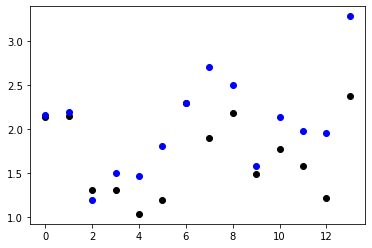

In [7]:
fig, ax = plt.subplots()
for i in range(14):
    ax.scatter(i, pkl_reffs[i], c='k')
    ax.scatter(i, slacs_reffs[i], c='b')

In [8]:
# My effective radii are smaller than SLACS

In [9]:
# Use surf, sigma, q, distance to get the major axis effective radius

# get luminosity distance to get luminosity from mge_isophote_whatever
distances = cosmo.luminosity_distance(zs).value

reffs = np.zeros(14)
reff_majs = np.zeros(14)
eps_reffs = np.zeros(14)
lums = np.zeros(14)

for i, obj_name in enumerate(obj_names):
    if i==6:
        reffs[i] = -1#slacs_reffs[i]
        reff_majs[i] = -1#slacs_reffs[i]
        eps_reffs[i] = -1
        lums[i] = -1
        continue
    file_dir = f'{data_dir}mosaics/{obj_name}/'
    surf, sigma, q, _, _, _, _, _, _, _, _ = prepare_to_jam(obj_name, file_dir)
    reff, reff_maj, eps_reff, lum = mge_half_light_isophote(surf, sigma, q, distances[i])
    reffs[i] = reff
    reff_majs[i] = reff_maj
    eps_reffs[i] = eps_reff
    lums[i] = lum





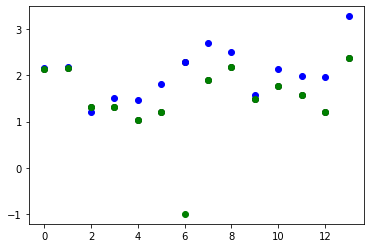

In [10]:
fig, ax = plt.subplots()
for i in range(14):
    ax.scatter(i, pkl_reffs[i], c='k')
    ax.scatter(i, slacs_reffs[i], c='b')
    ax.scatter(i, reffs[i], c='g')

# The measured effective radius (circular) is the same as in the pickle (because I used the same function on the same inputs).
_____________________________

# Functions to calculate V/sigma and Lambda_R

In [11]:
def calc_V_sigma_squared (delta, omega, alpha):
    
    numerator = (1-delta) * omega - 1
    denominator = alpha * (1-delta) * omega + 1
    
    V_sigma_sq = numerator/denominator
    
    return V_sigma_sq

def calc_omega (e):
    
    numerator = np.arcsin(e)/np.sqrt(1-e**2) - e
    denominator = e - np.arcsin(e) * np.sqrt(1-e**2)
    
    omega = 0.5 * numerator/denominator
    
    return omega

def calc_e (epsilon):
    
    e = np.sqrt( 1 - (1 - epsilon)**2 )
    
    return e

def calc_isotropic_V_sigma (epsilon):
    
    # isotropic delta = 0
    delta = 0
    # alpha empirically = 0.15
    alpha = 0.15
    
    # calculations
    e = calc_e(epsilon)
    omega = calc_omega(e)
    V_sigma_squared = calc_V_sigma_squared(delta, omega, alpha)
    V_sigma_iso = np.sqrt(V_sigma_squared)
    
    return(V_sigma_iso)

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


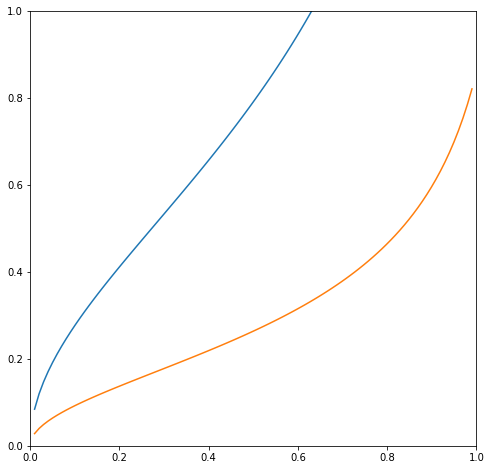

In [12]:
epsilons = np.linspace(0,1,100)
V_sigmas = np.zeros(100)

i=0
for epsilon in epsilons:
    V_sigma = calc_isotropic_V_sigma(epsilon)
    V_sigmas[i] = V_sigma
    i = i+1

plt.figure(figsize=(8,8))
plt.xlim(0.0,1.0)
plt.ylim(0.0,1.0)
plt.plot(epsilons, V_sigmas)
plt.plot(epsilons, 1/3 * V_sigmas)

In [13]:
# Define function to calculate luminosity weights for rebinning from Voronoi bins to shells
### In this case, the shell will justbe the effective radius (shells = [1])

def calc_luminosity_weights_in_shells (bin_arrays, num_bins, bin_luminosities, pixel_luminosities, shells, reff):
    
    # create array with each bin and len num_bins
    luminosity_weights = np.zeros((num_bins, len(shells)))
    
    for i in range(num_bins):
        # pixels in this bin, take x and y coordinates
        in_bin = bin_arrays[:,2]==i
        bin_pixels = bin_arrays[in_bin]
        bin_xx = bin_pixels[:,0] - 21 # subtract 21 pixels, center don't know which is x and which is y, but doesn't matter for R
        bin_yy = bin_pixels[:,1] - 21
        # luminosity of bin and of pixels in bin
        bin_luminosity = bin_luminosities[i]
        bin_pixels_lum = pixel_luminosities[in_bin]
        #print(bin_luminosity, np.sum(bin_pixels_lum))
        # calculate radius of each pixel in the bin
        bin_R = np.zeros(len(bin_pixels))
        for j in range(len(bin_pixels)):
            bin_R[j] = np.sqrt(bin_xx[j]**2 + bin_yy[j]**2)*0.1457 # arcsec
        # calculate fraction of these pixels in each shell
        for k in range(len(shells)):
            inner_shell = shells[k]
            if k == len(shells) - 1:
                outer_shell = 10 # everything extending to the farthest pixel
            else:
                outer_shell = shells[k+1]
            in_shell = (bin_R >= inner_shell*reff) & (bin_R <= outer_shell*reff)
            # weight pixels by fractional luminosity of total bin
            bin_luminosity_in_shell = np.sum(bin_pixels_lum[in_shell])#/bin_luminosity
            luminosity_weights[i,k] = bin_luminosity_in_shell
        
    return luminosity_weights

In [14]:
def lum_weight_bin (V, VD, dV, dVD, lum):
    
    bin_weighted_V_sq = lum * V**2
    bin_weighted_VD_sq = lum * VD**2
    bin_weighted_dV_sq = lum * 2 * V * dV
    bin_weighted_dVD_sq = lum * 2 * VD * dVD

    return bin_weighted_V_sq, bin_weighted_VD_sq, bin_weighted_dV_sq, bin_weighted_dVD_sq

def lum_weight_V_sigma (V_array, VD_array, dV_array, dVD_array, lum_array):
    
    assert (len(V_array)==len(VD_array)) & (len(V_array)==len(lum_array)) & (len(V_array)==len(dVD_array))
    
    V_sq = 0
    VD_sq = 0
    dV_sq = 0
    dVD_sq = 0
    
    for i in range(len(V_array)):
        bin_V_sq, bin_VD_sq, bin_dV_sq, bin_dVD_sq = lum_weight_bin(V_array[i], VD_array[i], dV_array[i], dVD_array[i], lum_array[i])
        V_sq += bin_V_sq
        VD_sq += bin_VD_sq
        dV_sq += bin_dV_sq
        dVD_sq += bin_dVD_sq
    
    V_sigma_sq = V_sq/VD_sq
    V_sigma = np.sqrt(V_sigma_sq)
    
    V_integrated_rms = np.sqrt(V_sq/np.sum(lum_array))
    VD_integrated_rms = np.sqrt(VD_sq/np.sum(lum_array))
    
    dV_int_rms = dV_sq / (2 * np.sqrt(np.sum(lum_array) * V_sq))
    dVD_int_rms = dVD_sq / (2 * np.sqrt(np.sum(lum_array) * VD_sq))
    
    return(V_sigma, V_integrated_rms, VD_integrated_rms, dV_int_rms, dVD_int_rms) # this is integrated out to the edge of my data right now
        

In [15]:
# Now let's do the lambda_R calculation


def calc_lambda_R (V_array, VD_array, R_array, lum_array):
    
    assert (len(V_array)==len(VD_array)) & (len(V_array)==len(lum_array)) & (len(V_array)==len(R_array))
    
    numerator = 0
    denominator = 0
    
    for i in range(len(V_array)):
        V = V_array[i]
        VD = VD_array[i]
        lum = lum_array[i]
        R = R_array[i]
        
        num = lum * R * np.abs(V)
        den = lum * R * np.sqrt(V**2 + VD**2)
        
        numerator += num
        denominator += den
        
    lambda_R = numerator / denominator
    
    return lambda_R


In [16]:
def calc_Vsig_to_lamR (V_sigma):
    k = 1.1
    numerator = k * V_sigma
    denominator = np.sqrt(1 + k**2 * V_sigma**2)
    lamR = numerator/denominator
    return lamR

In [17]:
def calc_R (bin_arrays, num_bins):
    
    bin_R_means = np.zeros(num_bins)
    
    for i in range(num_bins):
        bin_pixels = bin_arrays[bin_arrays[:,2]==i]
        bin_xx = bin_pixels[:,0] - 21 # subtract 21 pixels, center don't know which is x and which is y, but doesn't matter for R
        bin_yy = bin_pixels[:,1] - 21
        bin_R = np.zeros(len(bin_pixels))
        for j in range(len(bin_pixels)):
            bin_R[j] = np.sqrt(bin_xx[j]**2 + bin_yy[j]**2)
        bin_R_means[i] = np.mean(bin_R)*0.1457
        
    return bin_R_means
            

In [18]:
# Define function to assign velocities to each pixel from their Voronoi bin, taking only those within the effective radius

def calc_aperture_velocities_from_lum_weight_pixels_original (bin_arrays, V_array, VD_array, dV_array, dVD_array, pixel_luminosities, reff):
    
    # normalize pixel luminosities
    normalized_pixel_luminosities = pixel_luminosities/np.sum(pixel_luminosities)
    
    # create array for velocity of each pixel
    pixel_Vs = np.zeros(len(pixel_luminosities))
    pixel_VDs = np.zeros(len(pixel_luminosities))
    pixel_dVs = np.zeros(len(pixel_luminosities))
    pixel_dVDs = np.zeros(len(pixel_luminosities))
    velocity_in_aperture = 0
    
    for i in range(num_bins):
        # pixels in this bin
        in_bin = bin_arrays[:,2]==i
        bin_pixels = bin_arrays[in_bin]
        # add velocity to the weighted_pixel_velocities
        pixel_Vs[in_bin] = V_array[i]
        pixel_VDs[in_bin] = VD_array[i]
        pixel_dVs[in_bin] = dV_array[i]  
        pixel_dVDs[in_bin] = dVD_array[i]       
        
    # get radius of pixels
    pixel_xx = bin_arrays[:,0] - 21 # subtract 21 pixels, center don't know which is x and which is y, but doesn't matter for R
    pixel_yy = bin_arrays[:,1] - 21
    # calculate radius of each pixel
    pixel_radii = np.sqrt(pixel_xx**2 + pixel_yy**2)*0.1457 # arcsec
    # if they are in the effective radius
    in_aperture = (pixel_radii <= reff)
    
    # weight squared pixel velocities by pixel luminosity
    lum_weighted_pixel_Vs_sq = pixel_Vs**2 * normalized_pixel_luminosities
    lum_weighted_pixel_VDs_sq = pixel_VDs**2 * normalized_pixel_luminosities
    lum_weighted_pixel_dVs_sq = 2 * pixel_Vs * pixel_dVs * normalized_pixel_luminosities
    lum_weighted_pixel_dVDs_sq = 2 * pixel_VDs * pixel_dVDs * normalized_pixel_luminosities
    
    # take only those in the effective radius                                                   
    lum_weighted_aperture_V = np.sqrt(np.sum(lum_weighted_pixel_Vs_sq[in_aperture]))
    lum_weighted_aperture_VD = np.sqrt(np.sum(lum_weighted_pixel_VDs_sq[in_aperture]))
    lum_weighted_aperture_dV = np.sum(lum_weighted_pixel_dVs_sq[in_aperture]) / (2 * np.sqrt(np.sum(lum_weighted_pixel_Vs_sq[in_aperture])))
    lum_weighted_aperture_dVD = np.sum(lum_weighted_pixel_dVDs_sq[in_aperture]) / (2 * np.sqrt(np.sum(lum_weighted_pixel_VDs_sq[in_aperture])))
    
    # calculate V/sigma
    V_sigma = lum_weighted_aperture_V/lum_weighted_aperture_VD
    
    # calculate lambda_R
    numerator = np.sum(pixel_radii[in_aperture] * normalized_pixel_luminosities[in_aperture] * np.sqrt( lum_weighted_pixel_Vs_sq[in_aperture]))
    denominator = np.sum(pixel_radii[in_aperture] * normalized_pixel_luminosities[in_aperture] * np.sqrt( lum_weighted_pixel_Vs_sq[in_aperture] +  lum_weighted_pixel_VDs_sq[in_aperture]))
    lambda_R = numerator / denominator

    
    return V_sigma, lambda_R, lum_weighted_aperture_V, lum_weighted_aperture_VD, lum_weighted_aperture_dV, lum_weighted_aperture_dVD

# There is something wrong with my pixel weighting method. I think it's because I've normalized before taking the aperture, so the luminosity weights are all normalized to the full map. Then the larger the aperture, the more weights. They should be weighted and normalized after being downselected to the pixels in the aperture.

In [19]:
# Define function to assign velocities to each pixel from their Voronoi bin, taking only those within the effective radius

def calc_aperture_velocities_from_lum_weight_pixels (bin_arrays, V_array, VD_array, dV_array, dVD_array, pixel_luminosities, reff):
    
    # create array for velocity of each pixel
    pixel_Vs = np.zeros(len(pixel_luminosities))
    pixel_VDs = np.zeros(len(pixel_luminosities))
    pixel_dVs = np.zeros(len(pixel_luminosities))
    pixel_dVDs = np.zeros(len(pixel_luminosities))
    velocity_in_aperture = 0
    
    for i in range(num_bins):
        # pixels in this bin
        in_bin = bin_arrays[:,2]==i
        bin_pixels = bin_arrays[in_bin]
        # add velocity to the weighted_pixel_velocities
        pixel_Vs[in_bin] = V_array[i]
        pixel_VDs[in_bin] = VD_array[i]
        pixel_dVs[in_bin] = dV_array[i]  
        pixel_dVDs[in_bin] = dVD_array[i]       
        
    # get radius of pixels
    pixel_xx = bin_arrays[:,0] - 21 # subtract 21 pixels, center don't know which is x and which is y, but doesn't matter for R
    pixel_yy = bin_arrays[:,1] - 21
    # calculate radius of each pixel
    pixel_radii = np.sqrt(pixel_xx**2 + pixel_yy**2)*0.1457 # arcsec
    # if they are in the effective radius
    in_aperture = (pixel_radii <= reff)
    
    # take values only in the aperture for weighting
    pixel_Vs_aperture = pixel_Vs[in_aperture]
    pixel_VDs_aperture = pixel_VDs[in_aperture]
    pixel_dVs_aperture = pixel_dVs[in_aperture]
    pixel_dVDs_aperture = pixel_dVDs[in_aperture]
    pixel_luminosities_aperture = pixel_luminosities[in_aperture]
    # normalize pixel luminosities
    normalized_pixel_luminosities_aperture = pixel_luminosities_aperture/np.sum(pixel_luminosities_aperture)
    
    # weight squared pixel velocities by pixel luminosity
    lum_weighted_pixel_Vs_sq = pixel_Vs_aperture**2 * normalized_pixel_luminosities_aperture
    lum_weighted_pixel_VDs_sq = pixel_VDs_aperture**2 * normalized_pixel_luminosities_aperture
    lum_weighted_pixel_dVs_sq = 2 * pixel_Vs_aperture * pixel_dVs_aperture * normalized_pixel_luminosities_aperture
    lum_weighted_pixel_dVDs_sq = 2 * pixel_VDs_aperture * pixel_dVDs_aperture * normalized_pixel_luminosities_aperture
    
    # take the square root of the sum of the weighted square velocities in the aperture                                                
    lum_weighted_aperture_V = np.sqrt(np.sum(lum_weighted_pixel_Vs_sq))
    lum_weighted_aperture_VD = np.sqrt(np.sum(lum_weighted_pixel_VDs_sq))
    lum_weighted_aperture_dV = np.sum(lum_weighted_pixel_dVs_sq) / (2 * np.sqrt(np.sum(lum_weighted_pixel_Vs_sq)))
    lum_weighted_aperture_dVD = np.sum(lum_weighted_pixel_dVDs_sq) / (2 * np.sqrt(np.sum(lum_weighted_pixel_VDs_sq)))
    
    # calculate V/sigma
    V_sigma = lum_weighted_aperture_V/lum_weighted_aperture_VD
    
    # calculate lambda_R
    numerator = np.sum(pixel_radii[in_aperture] * normalized_pixel_luminosities_aperture * np.sqrt( lum_weighted_pixel_Vs_sq))
    denominator = np.sum(pixel_radii[in_aperture] * normalized_pixel_luminosities_aperture * np.sqrt( lum_weighted_pixel_Vs_sq +  lum_weighted_pixel_VDs_sq))
    lambda_R = numerator / denominator

    
    return V_sigma, lambda_R, lum_weighted_aperture_V, lum_weighted_aperture_VD, lum_weighted_aperture_dV, lum_weighted_aperture_dVD

length before cutting... 193
length after cutting... 186
length before cutting... 303
length after cutting... 280
length before cutting... 12
length after cutting... 8
length before cutting... 18
length after cutting... 15
length before cutting... 99
length after cutting... 67
length before cutting... 65
length after cutting... 46
length before cutting... 64
length after cutting... 64
length before cutting... 108
length after cutting... 95
length before cutting... 39
length after cutting... 37
length before cutting... 45
length after cutting... 34
length before cutting... 37
length after cutting... 33
length before cutting... 71
length after cutting... 59
length before cutting... 52
length after cutting... 40
length before cutting... 54
length after cutting... 50


(array([1., 7., 2., 1., 0., 0., 1., 0., 1., 1.]),
 array([0.04540957, 0.06304066, 0.08067176, 0.09830285, 0.11593394,
        0.13356503, 0.15119612, 0.16882721, 0.1864583 , 0.20408939,
        0.22172048]),
 <BarContainer object of 10 artists>)

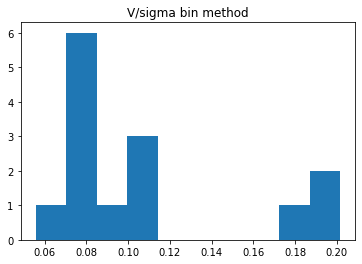

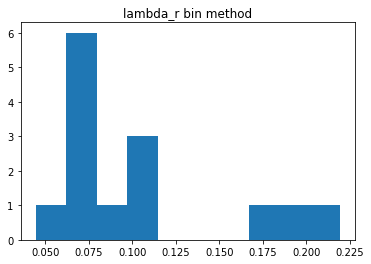

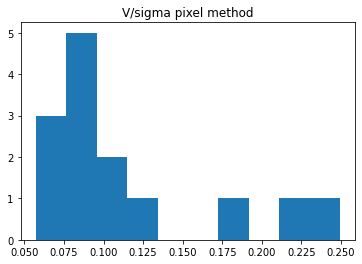

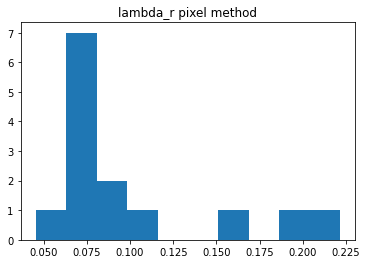

In [20]:
# plug in the extra steps of doing the integral over luminosity weighted pixels instead of just the bins. Will be more spatially accurate as an aperture of radius reff

V_sigmas_bin_method = np.zeros(len(obj_names))
lambda_Rs_bin_method = np.zeros(len(obj_names))
V_ap_int_rms_bin_method = np.zeros(len(obj_names))
VD_ap_int_rms_bin_method = np.zeros(len(obj_names))
dV_ap_int_rms_bin_method = np.zeros(len(obj_names))
dVD_ap_int_rms_bin_method = np.zeros(len(obj_names))

V_sigmas_pixel_method = np.zeros(len(obj_names))
lambda_Rs_pixel_method = np.zeros(len(obj_names))
V_ap_int_rms_pixel_method = np.zeros(len(obj_names))
VD_ap_int_rms_pixel_method = np.zeros(len(obj_names))
dV_ap_int_rms_pixel_method = np.zeros(len(obj_names))
dVD_ap_int_rms_pixel_method = np.zeros(len(obj_names))


for i, obj_name in enumerate(obj_names):
       
    #################
    # set up directories
    obj_abbr = obj_name[4:9] # e.g. J0029
    # data directory
    data_dir = '/data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/'
    # object directory
    dir = f'{data_dir}mosaics/{obj_name}/'
    #KCWI mosaic datacube
    name = f'KCWI_{obj_abbr}_icubes_mosaic_0.1457'
    save_dir = f'{dir}{obj_name}_systematics/'

    #################
    # get velocity and bin data 
    VD=np.genfromtxt(f'{dir}{obj_name}_final_kinematics/{obj_name}_VD_binned.txt',
             delimiter=',')
    VD_cov = np.genfromtxt(f'{dir}{obj_name}_final_kinematics/{obj_name}_covariance_matrix_VD.txt',
                     delimiter=',')
    dVD = np.sqrt(np.diagonal(VD_cov))
    V=np.genfromtxt(f'{dir}{obj_name}_final_kinematics/{obj_name}_V_binned.txt',
                     delimiter=',')
    # subtract the mean V
    V = V - np.mean(V)
    V_cov = np.genfromtxt(f'{dir}{obj_name}_final_kinematics/{obj_name}_covariance_matrix_V.txt',
                     delimiter=',')
    dV = np.sqrt(np.diagonal(V_cov))
    
    # import voronoi binning data (#bins, 5215), spectrum for each bin
    voronoi_binning_data = fits.getdata(dir +'voronoi_binning_' + name + '_data.fits')
    num_bins = len(voronoi_binning_data)
    # import pixel data for bins
    vorbin_pixels = np.genfromtxt(f'{dir}voronoi_2d_binning_{name}_output.txt',
                 delimiter='')
    
    #################
    # sum each bin across all wavelengths to get bin luminosities
    bin_luminosities = np.zeros(len(V))
    for j in range(len(V)):
        lum = np.sum(voronoi_binning_data[j])
        bin_luminosities[j] = lum
        

    #################
    # get mean R for each bin by pixel positions
    short_name = obj_name[4:]
    R = calc_R (vorbin_pixels, len(V))
    print(f'length before cutting... {len(R)}')
    if i==6:
        effective_radius = slacs_reffs[i]
    else:
        effective_radius = reffs[i]
    condition = R < effective_radius
    R_in_aperture = R[condition]
    V_in_aperture = V[condition]
    VD_in_aperture = VD[condition]
    dV_in_aperture = dV[condition]
    dVD_in_aperture = dVD[condition]
    bin_luminosities_in_aperture = bin_luminosities[condition]
    print(f'length after cutting... {len(R_in_aperture)}')
    #print()

    #################
    # calculate V_sigma
    V_sigmas_bin_method[i], \
        V_ap_int_rms_bin_method[i], \
        VD_ap_int_rms_bin_method[i], \
        dV_ap_int_rms_bin_method[i], \
        dVD_ap_int_rms_bin_method[i] = lum_weight_V_sigma ( V_in_aperture, 
                                                           VD_in_aperture, 
                                                           dV_in_aperture, 
                                                           dVD_in_aperture, 
                                                           bin_luminosities_in_aperture )
    # calculate lambda_R
    lambda_Rs_bin_method[i] = calc_lambda_R (V_in_aperture, VD_in_aperture, R_in_aperture, bin_luminosities_in_aperture)
    
    ###########################################
    # Now second method
    ###########################################
    
    # bring in cropped datacube and sum across wavelengths
    file = f'{dir}KCWI_{obj_abbr}_icubes_mosaic_0.1457_crop.fits'
    datacube = fits.open(file)[0].data
    summed_datacube = np.nansum(datacube, axis=0)
    normalized_summed_datacube = summed_datacube/np.sum(summed_datacube)
    
    # get effective radius
    #if obj_name == 'SDSSJ1306+0600':
    #    reff = 2.30
    #else:    
        # get reff from slacs table
    #    slacs_table = np.genfromtxt(f'{data_dir}slacs_tableA1.txt', delimiter='', dtype='U10')
    #    slacs_table_name = obj_name[4:]
    #    slacs_reffs = slacs_table[:,7].astype(float)
    #    reff = slacs_reffs[slacs_table[:,0]==slacs_table_name]
     
        
    # calculate pixel luminosities
    pixel_luminosities = np.zeros(len(vorbin_pixels))
    for j in range(len(vorbin_pixels)):
        x = int(vorbin_pixels[j,0])
        y = int(vorbin_pixels[j,1])
        pixel_luminosity = summed_datacube[y,x]
        pixel_luminosities[j] = pixel_luminosity

    # calculate luminosity weights for each bin contribution to the integrated velocities within the effective radius
    shells=[1.]
    luminosity_weights = calc_luminosity_weights_in_shells(vorbin_pixels, 
                                                           num_bins, 
                                                           bin_luminosities, 
                                                           pixel_luminosities, 
                                                           shells, 
                                                           effective_radius)
    
    # calculate the luminosity-weighted mean V and VD for the aperture within the effective radius
    sum_lum_weights = np.sum(luminosity_weights, axis=0) # sum over the weights for the normalization
    normalized_lum_weights = luminosity_weights / sum_lum_weights
    
    # calculate V_sigma# calculate lambda_R
    V_sigmas_pixel_method[i], lambda_Rs_pixel_method[i], \
        V_ap_int_rms_pixel_method[i], VD_ap_int_rms_pixel_method[i], \
        dV_ap_int_rms_pixel_method[i], dVD_ap_int_rms_pixel_method[i]  = calc_aperture_velocities_from_lum_weight_pixels(vorbin_pixels, 
                                                                                                                         V, VD, dV, dVD, 
                                                                                                                         pixel_luminosities, 
                                                                                                                         effective_radius)
    
    
plt.figure()    
plt.title('V/sigma bin method')
plt.hist(V_sigmas_bin_method)
plt.figure()
plt.title('lambda_r bin method')
plt.hist(lambda_Rs_bin_method)
    
plt.figure()    
plt.title('V/sigma pixel method')
plt.hist(V_sigmas_pixel_method)
plt.figure()
plt.title('lambda_r pixel method')
plt.hist(lambda_Rs_pixel_method)


In [21]:
# bring in my classifications table
date = '012323'
#class_df.to_csv(f'{data_dir}classification_table_{date}.csv',index=False)
classifications = pd.read_csv(f'{data_dir}classification_table_{date}.csv')

classes=classifications['class']

# add V_sigma and lambda_R, and ellipticities
classifications['SLACS ellipticity'] = slacs_ellipticities
classifications['effective_radius'] = reffs
classifications['reff_maj'] = reff_majs
classifications['eps reff ellipse'] = eps_reffs
classifications['luminosities'] = lums
classifications['SLACS reff'] = slacs_reffs
classifications['SLACS PA'] = slacs_PA_phots
# bin and pixel methods
classifications['V_sigma_bin'] = V_sigmas_bin_method
classifications['lambda_R_bin'] = lambda_Rs_bin_method
classifications['D_ap_bin'] = V_ap_int_rms_bin_method
classifications['dV_ap_bin'] = dV_ap_int_rms_bin_method
classifications['VD_ap_bin'] = VD_ap_int_rms_bin_method
classifications['dVD_ap_bin'] = dVD_ap_int_rms_bin_method
classifications['V_sigma_pix'] = V_sigmas_pixel_method
classifications['lambda_R_pix'] = lambda_Rs_pixel_method
classifications['V_ap_pix'] = V_ap_int_rms_pixel_method
classifications['dV_ap_pix'] = dV_ap_int_rms_pixel_method
classifications['VD_ap_pix'] = VD_ap_int_rms_pixel_method
classifications['dVD_ap_pix'] = dVD_ap_int_rms_pixel_method

In [22]:
classifications

,obj_name,class,subclass,comments,ellipticity,SLACS ellipticity,effective_radius,SLACS PA,V_sigma,lambda_R,...,D_ap_bin,dV_ap_bin,VD_ap_bin,dVD_ap_bin,V_sigma_pix,lambda_R_pix,V_ap_pix,dV_ap_pix,VD_ap_pix,dVD_ap_pix
0,SDSSJ0029-0055,slow/nonregular,"complex velocity, twist",V 60-80 km/s,0.13,0.160,2.135808,26.6,0.107911,0.084878,...,21.300831,0.669709,199.421918,13.654154,0.107813,0.084803,21.442244,0.569657,198.884195,13.839456
1,SDSSJ0037-0942,fast/regular,misaligned 31 deg,V 100 km/s,0.30,0.270,2.154388,11.4,0.176446,0.158571,...,45.783959,-0.231398,259.403231,12.931580,0.175390,0.157925,45.385773,-0.212616,258.770548,13.056962
2,SDSSJ0330-0020,uncertain,"possible rotation, misaligned 59 deg","Data poor, V 60 km/s",0.17,0.230,1.314216,109.6,0.129017,0.109658,...,25.219850,7.045236,222.992828,13.431018,0.133585,0.114256,29.887217,2.362038,223.732192,14.122650
3,SDSSJ1112+0826,fast/regular,aligned 0 deg,V 100 km/s,0.24,0.230,1.305929,137.5,0.263330,0.234192,...,49.646988,-0.462546,260.213207,6.317120,0.249413,0.221720,64.504280,0.641930,258.623869,6.460976
4,SDSSJ1204+0358,slow/nonregular,KDC,"V 40 km/s, signif arcs",0.09,0.030,1.038714,132.1,0.077882,0.068771,...,19.865330,0.076460,254.320344,6.891731,0.076323,0.067452,19.377556,-0.208844,253.889966,6.955204
5,SDSSJ1250+0523,fast/regular,"very round, alignment N/A","V 100 km/s, signif arcs",0.04,0.030,1.196016,114.8,0.127693,0.112299,...,20.407627,0.124028,231.192047,5.889335,0.086690,0.077890,20.050898,-0.623594,231.294729,5.946411
6,SDSSJ1306+0600,fast/regular,misaligned 25 deg,"V 60 km/s, No HST image yet",-1.00,0.091,-1.000000,0.0,0.108517,0.091037,...,24.722248,0.493455,224.659948,14.157014,0.108517,0.091037,24.439408,-0.091611,225.212018,13.921470
7,SDSSJ1402+6321,fast/regular,misaligned 35 deg,V 60 km/s,0.22,0.230,1.895980,70.8,0.095982,0.082576,...,19.754198,0.255959,274.194433,8.207197,0.081695,0.073092,22.183716,0.500573,271.543845,8.665381
8,SDSSJ1531-0105,slow/nonregular,"no rotation, complex velocity, misaligned 41 deg",V 40 deg,0.31,0.320,2.181738,143.5,0.078509,0.069539,...,18.365266,0.797455,257.115504,17.259474,0.076207,0.067164,19.513628,2.973917,256.061205,17.631056
9,SDSSJ1538+5817,fast/nonregular,"KDC, CRD? misaligned 22 deg","V 60 km/s outer, 20 deg inner",0.22,0.180,1.494048,153.5,0.064735,0.049908,...,12.735264,-0.606539,228.411447,9.361740,0.057229,0.045410,12.975210,-0.566280,226.725240,9.441672


In [23]:
date='020734'
#classifications.to_csv(f'{data_dir}classification_table_{date}.csv')

In [24]:
# change subclasses to reflect the correct delta_pa and uncertainty from kinematic pa.
classifications.loc[0, 'subclass'] = 'complex velocity, twist, misaligned 70 deg'
classifications.loc[1, 'subclass'] = 'misaligned 31 deg'
classifications.loc[2, 'subclass'] = 'possible rotation, misaligned 30 deg'
classifications.loc[3, 'subclass'] = 'aligned 0 deg'
classifications.loc[4, 'subclass'] = 'KDC?, misaligned 23 deg'
#classifications.loc[5, 'subclass'] = 'very round, '
#classifications.loc[6, 'subclass'] = ''
classifications.loc[7, 'subclass'] = 'very round, aligned 16 deg'
classifications.loc[8, 'subclass'] = 'no rotation, complex velocity, aligned 3 deg'
classifications.loc[9, 'subclass'] = 'KDC, CRD? core misaligned 22 deg, outer aligned'
classifications.loc[10, 'subclass'] = ' very round, aligned 19 deg'
classifications.loc[11, 'subclass'] = 'very round, complex velocity'
classifications.loc[12, 'subclass'] = 'misaligned 27 deg'
classifications.loc[13, 'subclass'] = 'twist, inner aligned, outer misaligned 22 deg'

In [25]:
# for this purpose, take the ellipticity of J1306 to be the SLACS ellipticity. DO NOT SAVE.
classifications.loc[6, 'ellipticity'] = classifications.loc[6, 'SLACS ellipticity']
classifications.loc[6, 'ellipticity_bspline'] = classifications.loc[6, 'SLACS ellipticity']

In [26]:
ellipticities = classifications.ellipticity_bspline

In [27]:
slow = classes == 'slow/nonregular'
fast = classes == 'fast/regular'
uncertain = classes == 'uncertain' # J0330
kdc = classes == 'fast/nonregular' #J1538

# separate into fast and slow
eps_slow = ellipticities[slow]
eps_fast = ellipticities[fast]

#################################################
#### pixel method
V_sigmas_pix_slow = V_sigmas_pixel_method[slow]
V_sigmas_pix_fast = V_sigmas_pixel_method[fast]

lambda_Rs_pix_slow = lambda_Rs_pixel_method[slow]
lambda_Rs_pix_fast = lambda_Rs_pixel_method[fast]

# uncertain
eps_uncertain = ellipticities[uncertain]
V_sigmas_pix_uncertain = V_sigmas_pixel_method[uncertain]
lambda_Rs_pix_uncertain = lambda_Rs_pixel_method[uncertain]

# fast nonregular
eps_fast_kdc = ellipticities[kdc]
V_sigmas_pix_fast_kdc = V_sigmas_pixel_method[kdc]
lambda_Rs_pix_fast_kdc = lambda_Rs_pixel_method[kdc]

#################################################
#### bin method
V_sigmas_bin_slow = V_sigmas_bin_method[slow]
V_sigmas_bin_fast = V_sigmas_bin_method[fast]

lambda_Rs_bin_slow = lambda_Rs_bin_method[slow]
lambda_Rs_bin_fast = lambda_Rs_bin_method[fast]

# uncertain
eps_uncertain = ellipticities[uncertain]
V_sigmas_bin_uncertain = V_sigmas_bin_method[uncertain]
lambda_Rs_bin_uncertain = lambda_Rs_bin_method[uncertain]

# fast nonregular
eps_fast_kdc = ellipticities[kdc]
V_sigmas_bin_fast_kdc = V_sigmas_bin_method[kdc]
lambda_Rs_bin_fast_kdc = lambda_Rs_bin_method[kdc]

In [28]:
# make elliptical marker
import matplotlib.path as mpath

# Define the ellipse marker.
circle = mpath.Path.unit_circle()
elliptical_verts = np.copy(circle.vertices)
elliptical_verts[:, 0] *= 1.618
elliptical_marker = mpath.Path(elliptical_verts, circle.codes)

# define negative smaller ellipse
inner_ell_verts = elliptical_verts * 0.8

In [29]:
# make ellipse with line marker
rect = mpath.Path.unit_rectangle()
rect_verts = np.copy(rect.vertices)
rect_verts[:,0] *= 0.1
rect_verts[:,1] *= 2.0
line_marker = mpath.Path(rect_verts, rect.codes)

# make another line marker lower
second_line_verts = rect_verts.copy()
second_line_verts[:,1] += -3.5
second_line_verts[:,1] *= 0.5

rotator = mpath.Path(
    vertices=np.concatenate([elliptical_verts, inner_ell_verts[::-1, ...], rect_verts, second_line_verts]),
    codes=np.concatenate([circle.codes, circle.codes, rect.codes, rect.codes]))

nonregular = 'o'

# make a question mark
uncertain_mark = '$?$'

# fast/non (kdc)
kdc_mark = '^'


# I'm taking the pixel method as the correct one for now, but I want to see how they look in comparison.

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


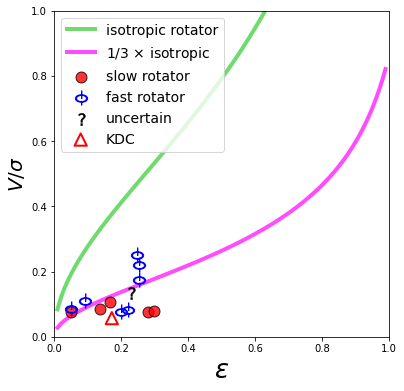

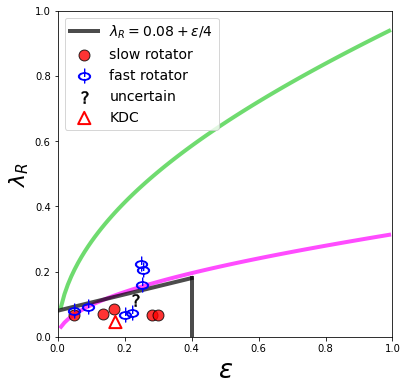

In [30]:
# plot the V_sigma and lambda_R to ellipticities


epsilons = np.linspace(0.0,1.0,100)
V_sigmas_iso = np.zeros(100)
lambda_Rs_iso = np.zeros(100)

i=0
for epsilon in epsilons:
    V_sigma = calc_isotropic_V_sigma(epsilon)
    V_sigmas_iso[i] = V_sigma
    lambda_Rs_iso[i] = calc_Vsig_to_lamR(V_sigma)
    i = i+1

# plot the V_sigma and lambda_R to ellipticities

###################################
# V sigma

plt.figure(figsize=(6,6))
plt.xlim(0.0,1.0)
plt.ylim(0.0,1.0)

# curves
plt.plot(epsilons, V_sigmas_iso, 
         c='limegreen',linewidth=4,zorder=-1, alpha=0.7,
        label='isotropic rotator')
plt.plot(epsilons, 1/3 * V_sigmas_iso, 
         c='magenta',linewidth=4,zorder=-1, alpha=0.7,
        label=r'1/3 $\times$ isotropic')

# scatter plot for the datapoints
plt.scatter(eps_slow, V_sigmas_pix_slow, 
            s=120, c='r', marker=nonregular, edgecolor='k', linewidth=1,
            label='slow rotator', alpha=0.8)
plt.scatter(eps_fast, V_sigmas_pix_fast, 
            s=230, c='b', marker=rotator, 
            label='fast rotator')
plt.scatter(eps_uncertain, V_sigmas_pix_uncertain, 
            s=150, c='k', marker=uncertain_mark, linewidth=0.5, 
            label='uncertain')
plt.scatter(eps_fast_kdc, V_sigmas_pix_fast_kdc, 
            s=150, marker='^', edgecolor='red', facecolor='none', linewidth=2, 
            label='KDC')

plt.xlabel(r'$\epsilon$',fontsize=26)
plt.ylabel(r'$V/\sigma$',fontsize=20)
plt.legend(fontsize=14)
plt.savefig(f'{data_dir}mosaics/kinematic_class_vsigma_pix.png')
plt.savefig(f'{data_dir}mosaics/kinematic_class_vsigma_pix.pdf')

###################################
# Lambda_R

plt.figure(figsize=(6,6))
plt.xlim(0.0,1.0)
plt.ylim(0.0,1.0)

# curves
plt.plot(epsilons, lambda_Rs_iso, 
         c='limegreen',linewidth=4,zorder=-1, alpha=0.7)
plt.plot(epsilons, 1/3 * lambda_Rs_iso, 
         c='magenta',linewidth=4,zorder=-1, alpha=0.7)
plt.plot([0.0, 0.4],[0.08, 0.08+0.4/4],
         linestyle='-',c='k',linewidth=4,zorder=-1, alpha=0.7)
plt.plot([0.4, 0.4],[0.0, 0.08+0.4/4],
         linestyle='-',c='k',linewidth=4,zorder=-1, alpha=0.7,
        label=r'$\lambda_R = 0.08 + \epsilon/4$')

# scatter plots for the datapoints
plt.scatter(eps_slow, lambda_Rs_pix_slow, 
            s=120, c='r', marker=nonregular, edgecolor='k', linewidth=1,
            label='slow rotator', alpha=0.8)
plt.scatter(eps_fast, lambda_Rs_pix_fast, 
            s=230, c='b', marker=rotator, 
            label='fast rotator')
plt.scatter(eps_uncertain, lambda_Rs_pix_uncertain, 
            s=150, c='k', marker=uncertain_mark, linewidth=0.5, 
            label='uncertain')
plt.scatter(eps_fast_kdc, lambda_Rs_pix_fast_kdc, 
            s=150, marker='^', edgecolor='red', facecolor='none', linewidth=2, 
            label='KDC')

plt.xlabel(r'$\epsilon$',fontsize=26)
plt.ylabel(r'$\lambda_R$',fontsize=22)
plt.legend(fontsize=14, loc='upper left')
plt.savefig(f'{data_dir}mosaics/kinematic_class_lambdar_pix.png')
plt.savefig(f'{data_dir}mosaics/kinematic_class_lambdar_pix.pdf')

# Let's add the SLACS and bspline ellipticities

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


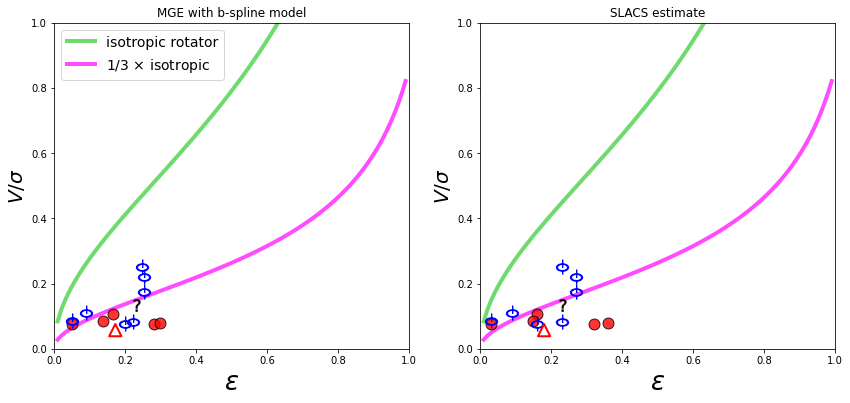

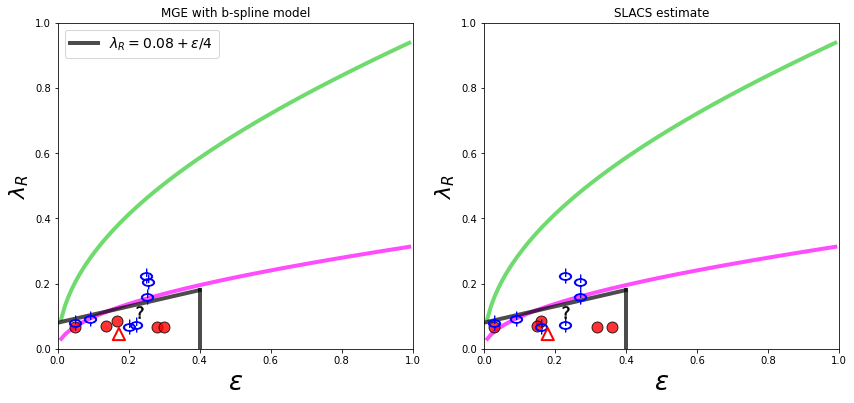

In [31]:
# plot the V_sigma and lambda_R to ellipticities


epsilons = np.linspace(0.0,1.0,100)
V_sigmas_iso = np.zeros(100)
lambda_Rs_iso = np.zeros(100)

i=0
for epsilon in epsilons:
    V_sigma = calc_isotropic_V_sigma(epsilon)
    V_sigmas_iso[i] = V_sigma
    lambda_Rs_iso[i] = calc_Vsig_to_lamR(V_sigma)
    i = i+1

# plot the V_sigma and lambda_R to ellipticities
###################################
# V sigma

fig, axs = plt.subplots(1, 2, figsize=(14,6))

for i in range(2):
    axs[i].set_xlim(0.0,1.0)
    axs[i].set_ylim(0.0,1.0)
    # curves
    axs[i].plot(epsilons, V_sigmas_iso, 
             c='limegreen',linewidth=4,zorder=-1, alpha=0.7,
            label='isotropic rotator')
    axs[i].plot(epsilons, 1/3 * V_sigmas_iso, 
             c='magenta',linewidth=4,zorder=-1, alpha=0.7,
            label=r'1/3 $\times$ isotropic')
    axs[i].set_xlabel(r'$\epsilon$',fontsize=26)
    axs[i].set_ylabel(r'$V/\sigma$',fontsize=20)
axs[0].legend(fontsize=14)

# initial models
#axs[0].scatter(eps_slow, V_sigmas_slow, 
#            s=120, c='r', marker=nonregular, edgecolor='k', linewidth=1,
#            label='slow rotator', alpha=0.8)
#axs[0].scatter(eps_fast, V_sigmas_fast, 
#            s=230, c='b', marker=rotator, 
#            label='fast rotator')
#axs[0].scatter(eps_uncertain, V_sigmas_uncertain, 
#            s=150, c='k', marker=uncertain_mark, linewidth=0.5, 
#            label='uncertain')
#axs[0].scatter(eps_fast_kdc, V_sigmas_fast_kdc, 
#            s=150, marker='^', edgecolor='red', facecolor='none', linewidth=2, 
#            label='KDC')

# slacs estimates
axs[1].scatter(classifications.loc[slow, 'SLACS ellipticity'], V_sigmas_pix_slow, 
            s=120, c='r', marker=nonregular, edgecolor='k', linewidth=1,
            label='slow rotator', alpha=0.8)
axs[1].scatter(classifications.loc[fast, 'SLACS ellipticity'], V_sigmas_pix_fast, 
            s=230, c='b', marker=rotator, 
            label='fast rotator')
axs[1].scatter(classifications.loc[uncertain, 'SLACS ellipticity'], V_sigmas_pix_uncertain, 
            s=150, c='k', marker=uncertain_mark, linewidth=0.5, 
            label='uncertain')
axs[1].scatter(classifications.loc[kdc, 'SLACS ellipticity'], V_sigmas_pix_fast_kdc, 
            s=150, marker='^', edgecolor='red', facecolor='none', linewidth=2, 
            label='KDC')

# bspline model
axs[0].scatter(classifications.loc[slow, 'ellipticity_bspline'], V_sigmas_pix_slow, 
            s=120, c='r', marker=nonregular, edgecolor='k', linewidth=1,
            label='slow rotator', alpha=0.8)
axs[0].scatter(classifications.loc[fast, 'ellipticity_bspline'], V_sigmas_pix_fast, 
            s=230, c='b', marker=rotator, 
            label='fast rotator')
axs[0].scatter(classifications.loc[uncertain, 'ellipticity_bspline'], V_sigmas_pix_uncertain, 
            s=150, c='k', marker=uncertain_mark, linewidth=0.5, 
            label='uncertain')
axs[0].scatter(classifications.loc[kdc, 'ellipticity_bspline'], V_sigmas_pix_fast_kdc, 
            s=150, marker='^', edgecolor='red', facecolor='none', linewidth=2, 
            label='KDC')

# titles
#axs[0].set_title('MGE with HST image')
axs[1].set_title('SLACS estimate')
axs[0].set_title('MGE with b-spline model')


plt.savefig(f'{data_dir}mosaics/kinematic_class_vsigma_pix_with_slacs_bspline.png')
plt.savefig(f'{data_dir}mosaics/kinematic_class_vsigma_pix_with_slacs_bspline.pdf')

###################################
# Lambda_R

fig, axs = plt.subplots(1, 2, figsize=(14,6))

for i in range(2):
    axs[i].set_xlim(0.0,1.0)
    axs[i].set_ylim(0.0,1.0)
    # curves
    axs[i].plot(epsilons, lambda_Rs_iso, 
             c='limegreen',linewidth=4,zorder=-1, alpha=0.7)
    axs[i].plot(epsilons, 1/3 * lambda_Rs_iso, 
             c='magenta',linewidth=4,zorder=-1, alpha=0.7)
    axs[i].plot([0.0, 0.4],[0.08, 0.08+0.4/4],
             linestyle='-',c='k',linewidth=4,zorder=-1, alpha=0.7)
    axs[i].plot([0.4, 0.4],[0.0, 0.08+0.4/4],
             linestyle='-',c='k',linewidth=4,zorder=-1, alpha=0.7,
        label=r'$\lambda_R = 0.08 + \epsilon/4$')
    axs[i].set_xlabel(r'$\epsilon$',fontsize=26)
    axs[i].set_ylabel(r'$\lambda_R$',fontsize=22)
axs[0].legend(fontsize=14)

# slacs estimates
axs[1].scatter(classifications.loc[slow, 'SLACS ellipticity'], lambda_Rs_pix_slow, 
            s=120, c='r', marker=nonregular, edgecolor='k', linewidth=1,
            label='slow rotator', alpha=0.8)
axs[1].scatter(classifications.loc[fast, 'SLACS ellipticity'], lambda_Rs_pix_fast, 
            s=230, c='b', marker=rotator, 
            label='fast rotator')
axs[1].scatter(classifications.loc[uncertain, 'SLACS ellipticity'], lambda_Rs_pix_uncertain, 
            s=150, c='k', marker=uncertain_mark, linewidth=0.5, 
            label='uncertain')
axs[1].scatter(classifications.loc[kdc, 'SLACS ellipticity'], lambda_Rs_pix_fast_kdc,
            s=150, marker='^', edgecolor='red', facecolor='none', linewidth=2, 
            label='KDC')

# bspline model
axs[0].scatter(classifications.loc[slow, 'ellipticity_bspline'], lambda_Rs_pix_slow, 
            s=120, c='r', marker=nonregular, edgecolor='k', linewidth=1,
            label='slow rotator', alpha=0.8)
axs[0].scatter(classifications.loc[fast, 'ellipticity_bspline'], lambda_Rs_pix_fast, 
            s=230, c='b', marker=rotator, 
            label='fast rotator')
axs[0].scatter(classifications.loc[uncertain, 'ellipticity_bspline'], lambda_Rs_pix_uncertain,
            s=150, c='k', marker=uncertain_mark, linewidth=0.5, 
            label='uncertain')
axs[0].scatter(classifications.loc[kdc, 'ellipticity_bspline'], lambda_Rs_pix_fast_kdc,
            s=150, marker='^', edgecolor='red', facecolor='none', linewidth=2, 
            label='KDC')

# titles
#axs[0].set_title('MGE with HST image')
axs[1].set_title('SLACS estimate')
axs[0].set_title('MGE with b-spline model')

plt.savefig(f'{data_dir}mosaics/kinematic_class_lambdar_pix_with_slacs_bspline.png')
plt.savefig(f'{data_dir}mosaics/kinematic_class_lambdar_pix_with_slacs_bspline.pdf')

# Now look at the pixel vs bin methods

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


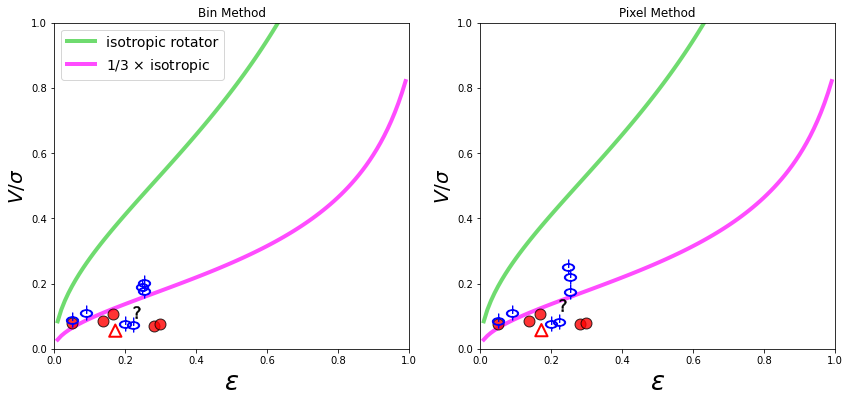

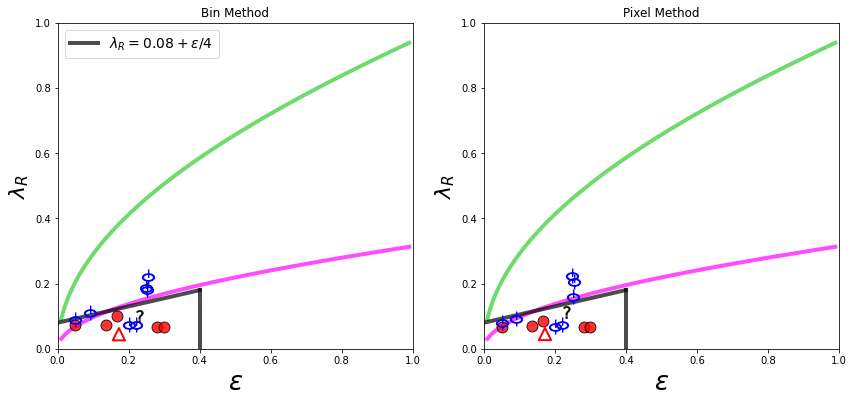

In [32]:
# plot the V_sigma and lambda_R to ellipticities


epsilons = np.linspace(0.0,1.0,100)
V_sigmas_iso = np.zeros(100)
lambda_Rs_iso = np.zeros(100)

i=0
for epsilon in epsilons:
    V_sigma = calc_isotropic_V_sigma(epsilon)
    V_sigmas_iso[i] = V_sigma
    lambda_Rs_iso[i] = calc_Vsig_to_lamR(V_sigma)
    i = i+1

# plot the V_sigma and lambda_R to ellipticities
###################################
# V sigma

fig, axs = plt.subplots(1, 2, figsize=(14,6))

for i in range(2):
    axs[i].set_xlim(0.0,1.0)
    axs[i].set_ylim(0.0,1.0)
    # curves
    axs[i].plot(epsilons, V_sigmas_iso, 
             c='limegreen',linewidth=4,zorder=-1, alpha=0.7,
            label='isotropic rotator')
    axs[i].plot(epsilons, 1/3 * V_sigmas_iso, 
             c='magenta',linewidth=4,zorder=-1, alpha=0.7,
            label=r'1/3 $\times$ isotropic')
    axs[i].set_xlabel(r'$\epsilon$',fontsize=26)
    axs[i].set_ylabel(r'$V/\sigma$',fontsize=20)
axs[0].legend(fontsize=14)

# initial models
#axs[0].scatter(eps_slow, V_sigmas_slow, 
#            s=120, c='r', marker=nonregular, edgecolor='k', linewidth=1,
#            label='slow rotator', alpha=0.8)
#axs[0].scatter(eps_fast, V_sigmas_fast, 
#            s=230, c='b', marker=rotator, 
#            label='fast rotator')
#axs[0].scatter(eps_uncertain, V_sigmas_uncertain, 
#            s=150, c='k', marker=uncertain_mark, linewidth=0.5, 
#            label='uncertain')
#axs[0].scatter(eps_fast_kdc, V_sigmas_fast_kdc, 
#            s=150, marker='^', edgecolor='red', facecolor='none', linewidth=2, 
#            label='KDC')

# slacs estimates
axs[1].scatter(classifications.loc[slow, 'ellipticity_bspline'], V_sigmas_pix_slow, 
            s=120, c='r', marker=nonregular, edgecolor='k', linewidth=1,
            label='slow rotator', alpha=0.8)
axs[1].scatter(classifications.loc[fast, 'ellipticity_bspline'], V_sigmas_pix_fast, 
            s=230, c='b', marker=rotator, 
            label='fast rotator')
axs[1].scatter(classifications.loc[uncertain, 'ellipticity_bspline'], V_sigmas_pix_uncertain, 
            s=150, c='k', marker=uncertain_mark, linewidth=0.5, 
            label='uncertain')
axs[1].scatter(classifications.loc[kdc, 'ellipticity_bspline'], V_sigmas_pix_fast_kdc, 
            s=150, marker='^', edgecolor='red', facecolor='none', linewidth=2, 
            label='KDC')

# bspline model
axs[0].scatter(classifications.loc[slow, 'ellipticity_bspline'], V_sigmas_bin_slow, 
            s=120, c='r', marker=nonregular, edgecolor='k', linewidth=1,
            label='slow rotator', alpha=0.8)
axs[0].scatter(classifications.loc[fast, 'ellipticity_bspline'], V_sigmas_bin_fast, 
            s=230, c='b', marker=rotator, 
            label='fast rotator')
axs[0].scatter(classifications.loc[uncertain, 'ellipticity_bspline'], V_sigmas_bin_uncertain, 
            s=150, c='k', marker=uncertain_mark, linewidth=0.5, 
            label='uncertain')
axs[0].scatter(classifications.loc[kdc, 'ellipticity_bspline'], V_sigmas_bin_fast_kdc, 
            s=150, marker='^', edgecolor='red', facecolor='none', linewidth=2, 
            label='KDC')

# titles
#axs[0].set_title('MGE with HST image')
axs[1].set_title('Pixel Method')
axs[0].set_title('Bin Method')


plt.savefig(f'{data_dir}mosaics/kinematic_class_vsigma_pix_vs_bin.png')
plt.savefig(f'{data_dir}mosaics/kinematic_class_vsigma_pix_vs_bin.pdf')

###################################
# Lambda_R

fig, axs = plt.subplots(1, 2, figsize=(14,6))

for i in range(2):
    axs[i].set_xlim(0.0,1.0)
    axs[i].set_ylim(0.0,1.0)
    # curves
    axs[i].plot(epsilons, lambda_Rs_iso, 
             c='limegreen',linewidth=4,zorder=-1, alpha=0.7)
    axs[i].plot(epsilons, 1/3 * lambda_Rs_iso, 
             c='magenta',linewidth=4,zorder=-1, alpha=0.7)
    axs[i].plot([0.0, 0.4],[0.08, 0.08+0.4/4],
             linestyle='-',c='k',linewidth=4,zorder=-1, alpha=0.7)
    axs[i].plot([0.4, 0.4],[0.0, 0.08+0.4/4],
             linestyle='-',c='k',linewidth=4,zorder=-1, alpha=0.7,
        label=r'$\lambda_R = 0.08 + \epsilon/4$')
    axs[i].set_xlabel(r'$\epsilon$',fontsize=26)
    axs[i].set_ylabel(r'$\lambda_R$',fontsize=22)
axs[0].legend(fontsize=14)

# slacs estimates
axs[1].scatter(classifications.loc[slow, 'ellipticity_bspline'], lambda_Rs_pix_slow, 
            s=120, c='r', marker=nonregular, edgecolor='k', linewidth=1,
            label='slow rotator', alpha=0.8)
axs[1].scatter(classifications.loc[fast, 'ellipticity_bspline'], lambda_Rs_pix_fast, 
            s=230, c='b', marker=rotator, 
            label='fast rotator')
axs[1].scatter(classifications.loc[uncertain, 'ellipticity_bspline'], lambda_Rs_pix_uncertain, 
            s=150, c='k', marker=uncertain_mark, linewidth=0.5, 
            label='uncertain')
axs[1].scatter(classifications.loc[kdc, 'ellipticity_bspline'], lambda_Rs_pix_fast_kdc,
            s=150, marker='^', edgecolor='red', facecolor='none', linewidth=2, 
            label='KDC')

# bspline model
axs[0].scatter(classifications.loc[slow, 'ellipticity_bspline'], lambda_Rs_bin_slow, 
            s=120, c='r', marker=nonregular, edgecolor='k', linewidth=1,
            label='slow rotator', alpha=0.8)
axs[0].scatter(classifications.loc[fast, 'ellipticity_bspline'], lambda_Rs_bin_fast, 
            s=230, c='b', marker=rotator, 
            label='fast rotator')
axs[0].scatter(classifications.loc[uncertain, 'ellipticity_bspline'], lambda_Rs_bin_uncertain,
            s=150, c='k', marker=uncertain_mark, linewidth=0.5, 
            label='uncertain')
axs[0].scatter(classifications.loc[kdc, 'ellipticity_bspline'], lambda_Rs_bin_fast_kdc,
            s=150, marker='^', edgecolor='red', facecolor='none', linewidth=2, 
            label='KDC')

# titles
#axs[0].set_title('MGE with HST image')
axs[1].set_title('Pixel Method')
axs[0].set_title('Bin Method')

plt.savefig(f'{data_dir}mosaics/kinematic_class_lambdar_pix_vs_bin.png')
plt.savefig(f'{data_dir}mosaics/kinematic_class_lambdar_pix_vs_bin.pdf')

# Whats the deal with these fast rotators being in the slow regime???

In [33]:
slow_fast = (V_sigmas_pixel_method < 0.12) & (classes != 'slow/nonregular')
classifications[slow_fast]

,obj_name,class,subclass,comments,ellipticity,SLACS ellipticity,effective_radius,SLACS PA,V_sigma,lambda_R,...,D_ap_bin,dV_ap_bin,VD_ap_bin,dVD_ap_bin,V_sigma_pix,lambda_R_pix,V_ap_pix,dV_ap_pix,VD_ap_pix,dVD_ap_pix
5,SDSSJ1250+0523,fast/regular,"very round, alignment N/A","V 100 km/s, signif arcs",0.040,0.030,1.196016,114.8,0.127693,0.112299,...,20.407627,0.124028,231.192047,5.889335,0.086690,0.077890,20.050898,-0.623594,231.294729,5.946411
6,SDSSJ1306+0600,fast/regular,misaligned 25 deg,"V 60 km/s, No HST image yet",0.091,0.091,-1.000000,0.0,0.108517,0.091037,...,24.722248,0.493455,224.659948,14.157014,0.108517,0.091037,24.439408,-0.091611,225.212018,13.921470
7,SDSSJ1402+6321,fast/regular,"very round, aligned 16 deg",V 60 km/s,0.220,0.230,1.895980,70.8,0.095982,0.082576,...,19.754198,0.255959,274.194433,8.207197,0.081695,0.073092,22.183716,0.500573,271.543845,8.665381
9,SDSSJ1538+5817,fast/nonregular,"KDC, CRD? core misaligned 22 deg, outer aligned","V 60 km/s outer, 20 deg inner",0.220,0.180,1.494048,153.5,0.064735,0.049908,...,12.735264,-0.606539,228.411447,9.361740,0.057229,0.045410,12.975210,-0.566280,226.725240,9.441672
12,SDSSJ1630+4520,fast/regular,misaligned 27 deg,V 60 deg,0.160,0.160,1.213994,71.7,0.113668,0.100951,...,19.687955,1.737335,263.611262,7.784503,0.077251,0.066614,20.337345,1.705894,263.263118,7.869573


In [34]:
fast_fast = (V_sigmas_pixel_method > 0.12)
classifications[fast_fast]

,obj_name,class,subclass,comments,ellipticity,SLACS ellipticity,effective_radius,SLACS PA,V_sigma,lambda_R,...,D_ap_bin,dV_ap_bin,VD_ap_bin,dVD_ap_bin,V_sigma_pix,lambda_R_pix,V_ap_pix,dV_ap_pix,VD_ap_pix,dVD_ap_pix
1,SDSSJ0037-0942,fast/regular,misaligned 31 deg,V 100 km/s,0.30,0.27,2.154388,11.4,0.176446,0.158571,...,45.783959,-0.231398,259.403231,12.931580,0.175390,0.157925,45.385773,-0.212616,258.770548,13.056962
2,SDSSJ0330-0020,uncertain,"possible rotation, misaligned 30 deg","Data poor, V 60 km/s",0.17,0.23,1.314216,109.6,0.129017,0.109658,...,25.219850,7.045236,222.992828,13.431018,0.133585,0.114256,29.887217,2.362038,223.732192,14.122650
3,SDSSJ1112+0826,fast/regular,aligned 0 deg,V 100 km/s,0.24,0.23,1.305929,137.5,0.263330,0.234192,...,49.646988,-0.462546,260.213207,6.317120,0.249413,0.221720,64.504280,0.641930,258.623869,6.460976
10,SDSSJ1621+3931,fast/regular,"very round, aligned 19 deg","V 100 km/s, pretty round",0.35,0.27,1.771849,142.9,0.235023,0.216519,...,50.197374,-1.159019,248.902914,11.660738,0.220208,0.203898,54.029451,-0.379746,245.356601,12.143671


# It looks like V = 60 km/s is not a great decider for fast vs slow in this case, should I start doing slow/regular?
# No, we should keep visual classification and Lambda_r classification separate.
# We need to look at stellar mass (M* > 2e11Msun) and velocity dispersion (sigma_e > 160 km/s) like Michele's email response
# But we should also include the classification by V_sigma/lambda_r

In [35]:
# classification according to the Cappellari paper

V_sigmas = classifications['V_sigma_pix']
lambda_Rs = classifications['lambda_R_pix']

V_sig_class = np.empty(14, dtype='U5')
lam_R_class = np.empty(14, dtype='U5')

for i in range(14):
    
    #print(obj_names[i])
    
    V_sig = V_sigmas[i]
    lam_R = lambda_Rs[i]
    ellip = ellipticities[i]
    
    V_sig_bound = calc_isotropic_V_sigma(ellip) / 3
    lam_R_bound = 0.08 + ellip/4
    
    if (V_sig < V_sig_bound):
        V_sig_class[i] = 'slow'
    elif (V_sig > V_sig_bound):
        V_sig_class[i] = 'fast'
    
    if (lam_R < lam_R_bound):
        lam_R_class[i] = 'slow'
    elif (lam_R > lam_R_bound):
        lam_R_class[i] = 'fast'
    
classifications['V_sigma_class'] = V_sig_class
classifications['lambda_R_class'] = lam_R_class

# Also add position angles, assuming the PA_phot is much more robust so uncertainty is dominated by dPA_kins.
# But how do I characterize the uncertainty on the photometric position angle?
# I can look at my measurement against SLACS measurement

In [36]:
PA_phots = np.array([203.42758808, 187.76112391, 104.22337576, 136.0986021 ,
                   135.08008317, 252.03377153,  -1.        , 255.30263871,
                   145.97245114, 153.33974639, 159.31355559, 185.74581685,
                   257.54008489, 208.0766188 ])

delta_PAs = np.abs([ 110.,   31.,  -30.,    0.,   23.,  143.,   -1.,  164.,   -3.,
                    22.,  199.,  125., -153.,  202.])

PA_kins = np.array([ 93. , 156.5, 134.5, 136. , 112. , 108.5,  -1. ,  90.5, 149.5,
                   130.5, -40.5,  60.5, 411. ,   5.5])

dPA_kins = np.array([27.75,  8.25, 89.75, 18.5 , 34.5 , 21.75, -1.  , 27.75, 89.75,
                   89.75, 19.25, 89.75, 34.  , 37.  ])

for i in range(14):
    if PA_phots[i] > 180:
        PA_phots[i] = PA_phots[i] - 180
    if delta_PAs[i] > 90:
        delta_PAs[i] = np.abs(180 - delta_PAs[i])
    if PA_kins[i] > 180:
        PA_kins[i] = PA_kins[i] - 180
    if dPA_kins[i] > 180:
        dPA_kins[i] = dPA_kins[i] - 180

In [37]:
classifications['PA_phot'] = PA_phots
classifications['delta_PA'] = delta_PAs
classifications['PA_kin'] = PA_kins
classifications['dPA_kin'] = dPA_kins

In [38]:
classifications[['SLACS PA', 'PA_phot']]

,SLACS PA,PA_phot
0,26.6,23.427588
1,11.4,7.761124
2,109.6,104.223376
3,137.5,136.098602
4,132.1,135.080083
5,114.8,72.033772
6,0.0,-1.000000
7,70.8,75.302639
8,143.5,145.972451
9,153.5,153.339746


# They are close.

In [39]:
classifications

,obj_name,class,subclass,comments,ellipticity,SLACS ellipticity,effective_radius,SLACS PA,V_sigma,lambda_R,...,VD_ap_bin,dVD_ap_bin,V_sigma_pix,lambda_R_pix,V_ap_pix,dV_ap_pix,VD_ap_pix,dVD_ap_pix,V_sigma_class,lambda_R_class
0,SDSSJ0029-0055,slow/nonregular,"complex velocity, twist, misaligned 70 deg",V 60-80 km/s,0.130,0.160,2.135808,26.6,0.107911,0.084878,...,199.421918,13.654154,0.107813,0.084803,21.442244,0.569657,198.884195,13.839456,slow,slow
1,SDSSJ0037-0942,fast/regular,misaligned 31 deg,V 100 km/s,0.300,0.270,2.154388,11.4,0.176446,0.158571,...,259.403231,12.931580,0.175390,0.157925,45.385773,-0.212616,258.770548,13.056962,fast,fast
2,SDSSJ0330-0020,uncertain,"possible rotation, misaligned 30 deg","Data poor, V 60 km/s",0.170,0.230,1.314216,109.6,0.129017,0.109658,...,222.992828,13.431018,0.133585,0.114256,29.887217,2.362038,223.732192,14.122650,slow,slow
3,SDSSJ1112+0826,fast/regular,aligned 0 deg,V 100 km/s,0.240,0.230,1.305929,137.5,0.263330,0.234192,...,260.213207,6.317120,0.249413,0.221720,64.504280,0.641930,258.623869,6.460976,fast,fast
4,SDSSJ1204+0358,slow/nonregular,"KDC?, misaligned 23 deg","V 40 km/s, signif arcs",0.090,0.030,1.038714,132.1,0.077882,0.068771,...,254.320344,6.891731,0.076323,0.067452,19.377556,-0.208844,253.889966,6.955204,fast,slow
5,SDSSJ1250+0523,fast/regular,"very round, alignment N/A","V 100 km/s, signif arcs",0.040,0.030,1.196016,114.8,0.127693,0.112299,...,231.192047,5.889335,0.086690,0.077890,20.050898,-0.623594,231.294729,5.946411,fast,slow
6,SDSSJ1306+0600,fast/regular,misaligned 25 deg,"V 60 km/s, No HST image yet",0.091,0.091,-1.000000,0.0,0.108517,0.091037,...,224.659948,14.157014,0.108517,0.091037,24.439408,-0.091611,225.212018,13.921470,fast,slow
7,SDSSJ1402+6321,fast/regular,"very round, aligned 16 deg",V 60 km/s,0.220,0.230,1.895980,70.8,0.095982,0.082576,...,274.194433,8.207197,0.081695,0.073092,22.183716,0.500573,271.543845,8.665381,slow,slow
8,SDSSJ1531-0105,slow/nonregular,"no rotation, complex velocity, aligned 3 deg",V 40 deg,0.310,0.320,2.181738,143.5,0.078509,0.069539,...,257.115504,17.259474,0.076207,0.067164,19.513628,2.973917,256.061205,17.631056,slow,slow
9,SDSSJ1538+5817,fast/nonregular,"KDC, CRD? core misaligned 22 deg, outer aligned","V 60 km/s outer, 20 deg inner",0.220,0.180,1.494048,153.5,0.064735,0.049908,...,228.411447,9.361740,0.057229,0.045410,12.975210,-0.566280,226.725240,9.441672,slow,slow


In [40]:
# bring in my classifications table
date = '020723'
#classifications.to_csv(f'{data_dir}classification_table_{date}.csv',index=False)
#classifications = pd.read_csv(f'{data_dir}classification_table_{date}.csv')

# Save the classifications table with the aperture integrated velocity, sigma, rms velocity, and uncertainty, and the SLACS velocity dispersion and error

In [41]:
V_aperture = V_ap_int_rms_pixel_method
VD_aperture = VD_ap_int_rms_pixel_method
dV_aperture = V_ap_int_rms_pixel_method
dVD_aperture = dVD_ap_int_rms_pixel_method
Vrms_aperture = np.sqrt((V_aperture**2 + VD_aperture**2)/2)

In [42]:
VD_aperture

array([198.88419488, 258.77054803, 223.73219216, 258.62386902,
       253.889966  , 231.29472948, 225.21201824, 271.54384472,
       256.06120459, 226.72524022, 245.35660125, 255.82366329,
       263.2631181 , 245.36817177])

In [43]:
classifications['V_aperture'] = V_aperture
classifications['VD_aperture'] = VD_aperture
classifications['dVD_aperture'] = dVD_aperture
classifications['Vrms_aperture'] = Vrms_aperture
classifications['SLACS VD'] = sdss_sigmas
classifications['SLACS dVD'] = sdss_sigmas_err

In [44]:
classifications

,obj_name,class,subclass,comments,ellipticity,SLACS ellipticity,effective_radius,SLACS PA,V_sigma,lambda_R,...,VD_ap_bin,dVD_ap_bin,V_sigma_pix,lambda_R_pix,V_ap_pix,dV_ap_pix,VD_ap_pix,dVD_ap_pix,V_sigma_class,lambda_R_class
0,SDSSJ0029-0055,slow/nonregular,"complex velocity, twist, misaligned 70 deg",V 60-80 km/s,0.130,0.160,2.135808,26.6,0.107911,0.084878,...,199.421918,13.654154,0.107813,0.084803,21.442244,0.569657,198.884195,13.839456,slow,slow
1,SDSSJ0037-0942,fast/regular,misaligned 31 deg,V 100 km/s,0.300,0.270,2.154388,11.4,0.176446,0.158571,...,259.403231,12.931580,0.175390,0.157925,45.385773,-0.212616,258.770548,13.056962,fast,fast
2,SDSSJ0330-0020,uncertain,"possible rotation, misaligned 30 deg","Data poor, V 60 km/s",0.170,0.230,1.314216,109.6,0.129017,0.109658,...,222.992828,13.431018,0.133585,0.114256,29.887217,2.362038,223.732192,14.122650,slow,slow
3,SDSSJ1112+0826,fast/regular,aligned 0 deg,V 100 km/s,0.240,0.230,1.305929,137.5,0.263330,0.234192,...,260.213207,6.317120,0.249413,0.221720,64.504280,0.641930,258.623869,6.460976,fast,fast
4,SDSSJ1204+0358,slow/nonregular,"KDC?, misaligned 23 deg","V 40 km/s, signif arcs",0.090,0.030,1.038714,132.1,0.077882,0.068771,...,254.320344,6.891731,0.076323,0.067452,19.377556,-0.208844,253.889966,6.955204,fast,slow
5,SDSSJ1250+0523,fast/regular,"very round, alignment N/A","V 100 km/s, signif arcs",0.040,0.030,1.196016,114.8,0.127693,0.112299,...,231.192047,5.889335,0.086690,0.077890,20.050898,-0.623594,231.294729,5.946411,fast,slow
6,SDSSJ1306+0600,fast/regular,misaligned 25 deg,"V 60 km/s, No HST image yet",0.091,0.091,-1.000000,0.0,0.108517,0.091037,...,224.659948,14.157014,0.108517,0.091037,24.439408,-0.091611,225.212018,13.921470,fast,slow
7,SDSSJ1402+6321,fast/regular,"very round, aligned 16 deg",V 60 km/s,0.220,0.230,1.895980,70.8,0.095982,0.082576,...,274.194433,8.207197,0.081695,0.073092,22.183716,0.500573,271.543845,8.665381,slow,slow
8,SDSSJ1531-0105,slow/nonregular,"no rotation, complex velocity, aligned 3 deg",V 40 deg,0.310,0.320,2.181738,143.5,0.078509,0.069539,...,257.115504,17.259474,0.076207,0.067164,19.513628,2.973917,256.061205,17.631056,slow,slow
9,SDSSJ1538+5817,fast/nonregular,"KDC, CRD? core misaligned 22 deg, outer aligned","V 60 km/s outer, 20 deg inner",0.220,0.180,1.494048,153.5,0.064735,0.049908,...,228.411447,9.361740,0.057229,0.045410,12.975210,-0.566280,226.725240,9.441672,slow,slow


# Michele said sigma_e > 160 km/s would be a good division

(array([1., 0., 0., 3., 1., 0., 2., 3., 3., 1.]),
 array([198.88419488, 206.15015986, 213.41612485, 220.68208983,
        227.94805481, 235.2140198 , 242.47998478, 249.74594976,
        257.01191475, 264.27787973, 271.54384472]),
 <BarContainer object of 10 artists>)

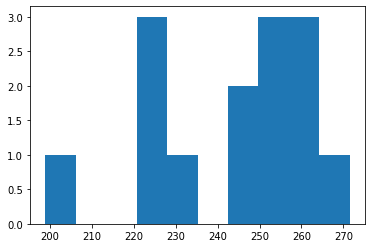

In [45]:
plt.hist(classifications['VD_ap_pix'])

# Every single one of them is more than 160 km/s

In [46]:
VD_ap_int_rms_bin_method - VD_ap_int_rms_pixel_method

array([ 0.53772265,  0.63268254, -0.73936396,  1.58933764,  0.43037783,
       -0.10268256, -0.55206986,  2.6505882 ,  1.05429928,  1.68620688,
        3.54631245,  2.05839168,  0.34814377,  0.82545756])

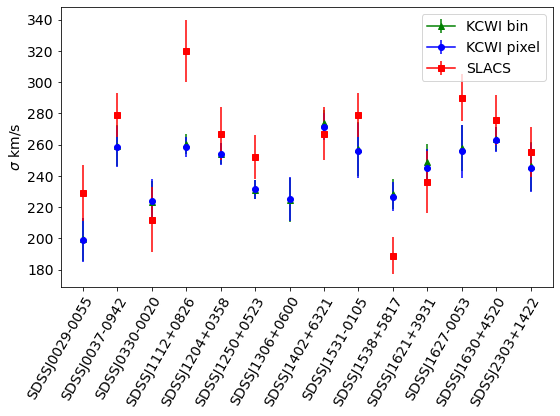

In [47]:
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(8,6))
for i in range(14):
    plt.errorbar(i, VD_ap_int_rms_bin_method[i], yerr=dVD_ap_int_rms_bin_method[i], c='g', marker='^')
    plt.errorbar(i, VD_ap_int_rms_pixel_method[i], yerr=dVD_ap_int_rms_pixel_method[i], c='b', marker='o')
    if i==6:
        continue
    plt.errorbar(i, sdss_sigmas[i], yerr=sdss_sigmas_err[i], c='r', marker='s')
    if i==0:
        plt.legend(['KCWI bin', 'KCWI pixel', 'SLACS'])
plt.xticks(range(14), labels=obj_names, rotation=60, ha='right', rotation_mode='anchor')
plt.ylabel(r'$\sigma$ km/s')
plt.tight_layout()
plt.savefig(f'{data_dir}aperture_integrated_velocity_dispersions_bin_pixel_{date}.pdf')

# So the bin method estimates higher velocity dispersions, and SLACS is even a little higher.

In [48]:
np.mean((VD_ap_int_rms_bin_method - VD_ap_int_rms_pixel_method)/VD_ap_int_rms_pixel_method)

0.003949384584907331

In [49]:
np.mean(dVD_ap_int_rms_pixel_method/VD_ap_int_rms_pixel_method)

0.04828789572305912

In [50]:
np.mean((V_ap_int_rms_bin_method - V_ap_int_rms_pixel_method)/V_ap_int_rms_pixel_method)

-0.046867471346332366

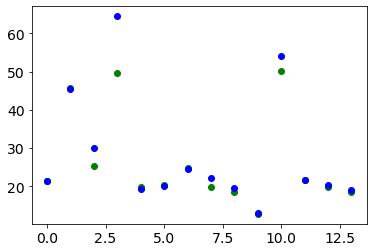

In [51]:
for i in range(len(obj_names)):
    plt.scatter(i, V_ap_int_rms_bin_method[i], c='g')
    plt.scatter(i, V_ap_int_rms_pixel_method[i], c='b')

# Velocity dispersion estimates are almost exactly the same. Velocities are not. Go with the pixel one.

In [52]:
obj_names

['SDSSJ0029-0055',
 'SDSSJ0037-0942',
 'SDSSJ0330-0020',
 'SDSSJ1112+0826',
 'SDSSJ1204+0358',
 'SDSSJ1250+0523',
 'SDSSJ1306+0600',
 'SDSSJ1402+6321',
 'SDSSJ1531-0105',
 'SDSSJ1538+5817',
 'SDSSJ1621+3931',
 'SDSSJ1627-0053',
 'SDSSJ1630+4520',
 'SDSSJ2303+1422']

In [53]:
# 02/06/23 - Bring in the VIMOS velocity dispersion from Czoske 2011 (paper IV)

VD_vimos = np.array([-1,
                    245.3,
                    -1,
                    -1,
                    240.8,
                    219.9,
                    -1,
                    -1,
                    -1,
                    -1,
                    -1,
                    272.6,
                     -1,
                    301.5])

dVD_vimos = np.array([-1,
                     7.1,
                     -1,
                     -1,
                     9.4,
                     5.6,
                     -1,
                     -1,
                     -1,
                     -1,
                     -1,
                     8.4,
                     -1,
                     7.1])

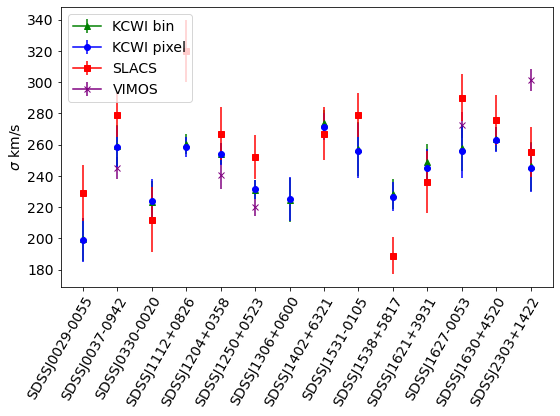

In [54]:
plt.figure(figsize=(8,6))
for i in range(14):
    if VD_vimos[i] != -1:
        plt.errorbar(i, VD_vimos[i], yerr=dVD_vimos[i], c='purple', marker='x')
    plt.errorbar(i, VD_ap_int_rms_bin_method[i], yerr=dVD_ap_int_rms_bin_method[i], c='g', marker='^')
    plt.errorbar(i, VD_ap_int_rms_pixel_method[i], yerr=dVD_ap_int_rms_pixel_method[i], c='b', marker='o')
    if i==6:
        continue
    plt.errorbar(i, sdss_sigmas[i], yerr=sdss_sigmas_err[i], c='r', marker='s')
    if i == 1:
        plt.legend(['KCWI bin', 'KCWI pixel', 'SLACS', 'VIMOS'], loc='upper left')
plt.xticks(range(14), labels=obj_names, rotation=60, ha='right', rotation_mode='anchor')
plt.ylabel(r'$\sigma$ km/s')
plt.tight_layout()
plt.savefig(f'{data_dir}aperture_integrated_velocity_dispersions_bin_pix_vimos_{date}.pdf')

# Look at stellar masses from https://arxiv.org/pdf/1407.5633.pdf
## Take Mag_r, M/L_r from tables 1 and 2
## See how they split across M_* = 2e11 M_sun

In [55]:
# take the sdss r mag
r_mags = np.array([-22.79,
                  -23.20,
                  -22.93,
                  -23.02,
                   -22.16,
                   -23.11,
                   0.0,
                   -23.14,
                   -23.04,
                   -21.98,
                   -23.22,
                   -22.78,
                   -23.18,
                   -22.83
                  ])

# solar magnitude in sdss r
mag_sun_r = 4.64 # (Blanton & Roweis 2007)

# convert to luminosity
lum_rs = 10**(0.4*(mag_sun_r - r_mags)) # solar luminosities

# take the ml_MFL, logs
log_ml_rs = np.array([0.693,
                     0.665,
                     0.487,
                     0.793,
                     0.835,
                     0.548, 
                      -1.0,
                      0.706, 
                     0.728,
                     0.577,
                     0.571,
                     0.830,
                     0.671,
                     0.779])

# convert from log
ml_rs = 10**log_ml_rs

# multiply mass to light by the light to get mass
stellar_masses = ml_rs * lum_rs

stellar_masses

array([4.62381021e+11, 6.32411851e+11, 3.27340695e+11, 7.19448978e+11,
       3.58921935e+11, 4.44631267e+11, 7.17794291e+00, 6.57657837e+11,
       6.30957344e+11, 1.67880402e+11, 5.18800039e+11, 6.28058359e+11,
       6.29506183e+11, 5.84790084e+11])

In [56]:
lum_rs

array([9.37562007e+10, 1.36772883e+11, 1.06659612e+11, 1.15877736e+11,
       5.24807460e+10, 1.25892541e+11, 7.17794291e+01, 1.29419584e+11,
       1.18032064e+11, 4.44631267e+10, 1.39315680e+11, 9.28966387e+10,
       1.34276496e+11, 9.72747224e+10])

In [57]:
classifications.luminosities

0     8.815578e+10
1     9.906234e+09
2     1.061384e+11
3     1.186472e+11
4     3.416879e+09
5     7.695768e+09
6    -1.000000e+00
7     7.163412e+09
8     1.150250e+11
9     4.710922e+10
10    8.621597e+09
11    4.495986e+09
12    5.721467e+09
13    5.919816e+09
Name: luminosities, dtype: float64

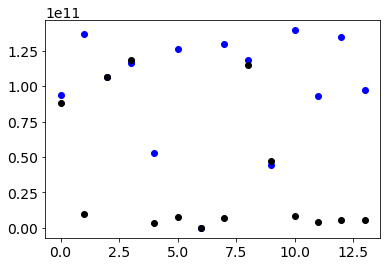

In [58]:
for i in range(14):
    plt.scatter(i, lum_rs[i], c='b')
    plt.scatter(i, classifications.loc[i, 'luminosities'], c='k')

In [59]:
# from https://ui.adsabs.harvard.edu/abs/2009ApJ...705.1099A/abstract
# stellar masses are in log
log_stellar_masses_salp = np.array([11.58,
                                   11.73,
                                   11.58,
                                   11.76,
                                   11.45,
                                   11.77,
                                   11.43,
                                   11.79,
                                   11.68,
                                   11.28,
                                   11.70,
                                   11.70,
                                   11.86,
                                   11.71]) 

# take from log
stellar_masses_salp = 10**log_stellar_masses_salp

# convert to scientific notation
for i in range(len(stellar_masses_salp)):
    sci = np.format_float_scientific(stellar_masses_salp[i])
    stellar_masses_salp[i] = sci

stellar_masses_salp

array([3.80189396e+11, 5.37031796e+11, 3.80189396e+11, 5.75439937e+11,
       2.81838293e+11, 5.88843655e+11, 2.69153480e+11, 6.16595002e+11,
       4.78630092e+11, 1.90546072e+11, 5.01187234e+11, 5.01187234e+11,
       7.24435960e+11, 5.12861384e+11])

In [60]:
# add the stellar masses
classifications['stellar_mass'] = stellar_masses
# for i=6 use salp
classifications.loc[6, 'stellar_mass'] = stellar_masses_salp[6]

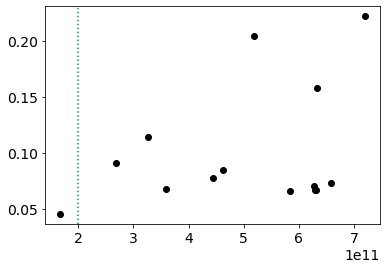

In [61]:
# plot against lambda_R
colors=['k','b','g','r']
plt.scatter(classifications['stellar_mass'], lambda_Rs, color='k')
plt.axvline(2e11, linestyle=':')

# Plot the lambda_R against basically everything else

In [62]:
classifications.columns

Index(['obj_name', 'class', 'subclass', 'comments', 'ellipticity',
       'SLACS ellipticity', 'effective_radius', 'SLACS PA', 'V_sigma',
       'lambda_R', 'PA_phot', 'delta_PA', 'PA_kin', 'dPA_kin',
       'oblate_prolate', 'SLACS delta_PA', 'V_aperture', 'VD_aperture',
       'dVD_aperture', 'Vrms_aperture', 'SLACS VD', 'SLACS dVD',
       'PA_kin_bspline', 'dPA_kin_bspline', 'PA_phot_bspline',
       'delta_PA_bspline', 'ellipticity_bspline', 'kcwi_sigmapsf_bspline',
       'reff_maj', 'eps reff ellipse', 'luminosities', 'SLACS reff',
       'V_sigma_bin', 'lambda_R_bin', 'D_ap_bin', 'dV_ap_bin', 'VD_ap_bin',
       'dVD_ap_bin', 'V_sigma_pix', 'lambda_R_pix', 'V_ap_pix', 'dV_ap_pix',
       'VD_ap_pix', 'dVD_ap_pix', 'V_sigma_class', 'lambda_R_class',
       'stellar_mass'],
      dtype='object')

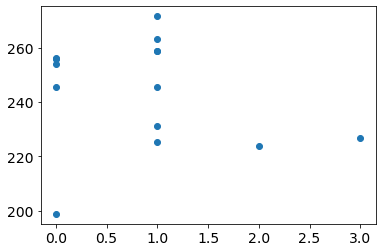

In [63]:
classes_num = np.empty(14, dtype='int64')
labels_again = np.empty(14, dtype='U15')
for i in range(14):
    if classifications.loc[i, 'class'] == 'slow/nonregular':
        classes_num[i] = 0
        labels_again[i] = 'slow/nonregular'
    elif classifications.loc[i, 'class'] == 'fast/regular':
        classes_num[i] = 1
        labels_again[i] = 'fast/regular'
    elif classifications.loc[i, 'class'] == 'uncertain':
        classes_num[i] = 2
        labels_again[i] = 'uncertain'
    else:
        classes_num[i] = 3
        labels_again[i] = 'KDC'
plt.scatter(classes_num, VD_aperture)

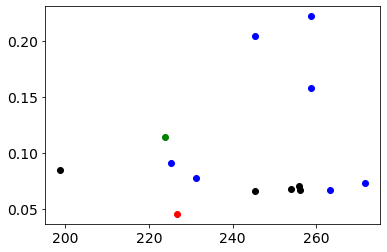

In [64]:
colors=['k','b','g','r']
for i in range(14):
    class_num = classes_num[i]
    plt.scatter(VD_aperture[i], lambda_Rs[i], color=colors[class_num])
#plt.legend()

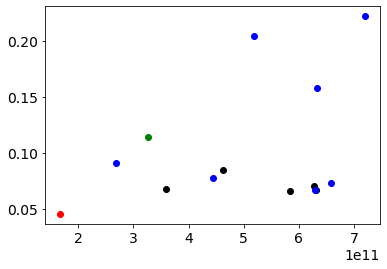

In [65]:
colors=['k','b','g','r']
for i in range(14):
    class_num = classes_num[i]
    plt.scatter(classifications.loc[i, 'stellar_mass'], lambda_Rs[i], color=colors[class_num])
#plt.legend()

In [66]:
slow_rotators = classifications[classes_num == 0]
regular_rotators = classifications[classes_num == 1]
uncertain_object = classifications[classes_num == 2]
kdc_object = classifications[classes_num == 3]


In [67]:
date = '020723'

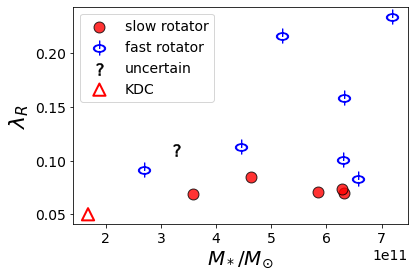

In [68]:
# scatter plot for the datapoints
plt.scatter(slow_rotators['stellar_mass'], slow_rotators['lambda_R'], 
            s=120, c='r', marker=nonregular, edgecolor='k', linewidth=1,
            label='slow rotator', alpha=0.8)
plt.scatter(regular_rotators['stellar_mass'], regular_rotators['lambda_R'], 
            s=230, c='b', marker=rotator, 
            label='fast rotator')
plt.scatter(uncertain_object['stellar_mass'], uncertain_object['lambda_R'], 
            s=150, c='k', marker=uncertain_mark, linewidth=0.5, 
            label='uncertain')
plt.scatter(kdc_object['stellar_mass'], kdc_object['lambda_R'], 
            s=150, marker='^', edgecolor='red', facecolor='none', linewidth=2, 
            label='KDC')
plt.xlabel(r'$M_*/M_{\odot}$', fontsize=20)
plt.ylabel(r'$\lambda_R$', fontsize=22)
plt.legend(fontsize=14, loc='upper left')
plt.savefig(f'{data_dir}lambdar_mstar_{date}.pdf')

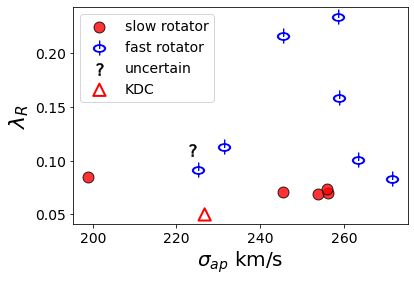

In [69]:
# scatter plot for the datapoints
plt.scatter(slow_rotators['VD_aperture'], slow_rotators['lambda_R'], 
            s=120, c='r', marker=nonregular, edgecolor='k', linewidth=1,
            label='slow rotator', alpha=0.8)
plt.scatter(regular_rotators['VD_aperture'], regular_rotators['lambda_R'], 
            s=230, c='b', marker=rotator, 
            label='fast rotator')
plt.scatter(uncertain_object['VD_aperture'], uncertain_object['lambda_R'], 
            s=150, c='k', marker=uncertain_mark, linewidth=0.5, 
            label='uncertain')
plt.scatter(kdc_object['VD_aperture'], kdc_object['lambda_R'], 
            s=150, marker='^', edgecolor='red', facecolor='none', linewidth=2, 
            label='KDC')
plt.xlabel(r'$\sigma_{ap}$ km/s', fontsize=20)
plt.ylabel(r'$\lambda_R$', fontsize=22)
plt.legend(fontsize=14, loc='upper left')
plt.savefig(f'{data_dir}lambdar_sigma_{date}.pdf')

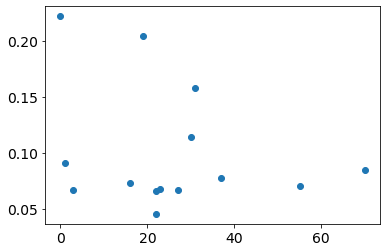

In [70]:
plt.scatter(classifications['delta_PA'], lambda_Rs)

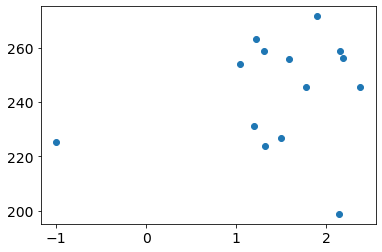

In [71]:
plt.scatter(classifications['effective_radius'], VD_aperture)

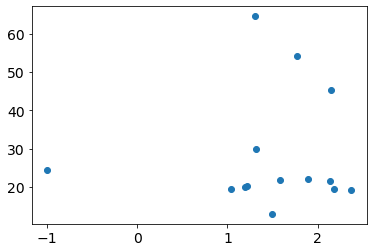

In [72]:
plt.scatter(classifications['effective_radius'], V_aperture)

(0.0, 0.5)

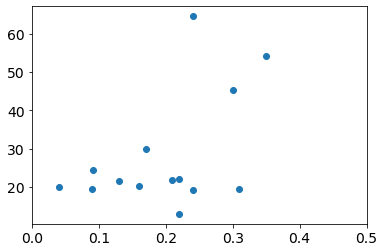

In [73]:
plt.scatter(classifications['ellipticity'], V_aperture)
plt.xlim(0, 0.5)

_________________________________
# 02/06/23 - Make a mass estimate from the virial theorem:
# $ \frac{3}{5} \frac{G M}{R} = \frac{1}{2} V^2 = \frac{3}{2} \sigma^2$

or

# $ M_{dyn} = \frac{5 r_{eff} \sigma^2}{2 G}$

In [74]:
import astropy.constants as c
import astropy.units as u

In [75]:
G_unit = c.G.to(u.kpc * u.km**2 / u.M_sun / u.s**2)

In [76]:
G_unit

<Quantity 4.30091727e-06 km2 kpc / (s2 solMass)>

In [77]:
slacs_reffs = classifications['SLACS reff']
reffs = classifications['effective_radius']
#reffs[6] = classifications.loc[6, 'SLACS reff']
reff_majs = classifications['reff_maj']

In [78]:
from astropy.cosmology import Planck15 as cosmo
reffs_kpc = cosmo.angular_diameter_distance(zs).to(u.kpc)*reffs/206265
reffs_slacs_kpc = cosmo.angular_diameter_distance(zs).to(u.kpc)*slacs_reffs/206265
reff_majs_kpc = cosmo.angular_diameter_distance(zs).to(u.kpc)*reff_majs/206265
reffs_kpc

<Quantity [ 8.01722808,  7.20634938,  6.70199577,  5.61485864,  3.0235612 ,
            4.56091683, -1.28955834,  6.57172917,  6.19834877,  3.86992234,
            7.03960974,  5.55186769,  4.8667864 ,  6.59771606] kpc>

In [79]:
# calculate the dynamical mass from integrated velocity dispersion
M_dyn = 5 * reffs_kpc * (classifications.VD_ap_pix)**2 / (2 * G_unit)* (u.km/u.s)**2
M_dyn


<Quantity [ 1.84333259e+11,  2.80494226e+11,  1.95002431e+11,
            2.18300613e+11,  1.13289265e+11,  1.41828185e+11,
           -3.80192058e+10,  2.81668644e+11,  2.36234051e+11,
            1.15632765e+11,  2.46333228e+11,  2.11202694e+11,
            1.96065530e+11,  2.30892058e+11] solMass>

In [80]:
classifications.stellar_mass

0     4.623810e+11
1     6.324119e+11
2     3.273407e+11
3     7.194490e+11
4     3.589219e+11
5     4.446313e+11
6     2.691535e+11
7     6.576578e+11
8     6.309573e+11
9     1.678804e+11
10    5.188000e+11
11    6.280584e+11
12    6.295062e+11
13    5.847901e+11
Name: stellar_mass, dtype: float64

In [96]:
# look in log space
log_Mdyn = np.log10(M_dyn.value)
log_Mstar = np.log10(classifications.stellar_mass[not_na])

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  


In [98]:
not_na = np.isfinite(log_Mdyn)

In [99]:
# linear fit in log space
m, b = np.polyfit(log_Mdyn[not_na], log_Mstar[not_na], deg=1)
print(m, b)

1.038846921909169 -0.04205842997030968


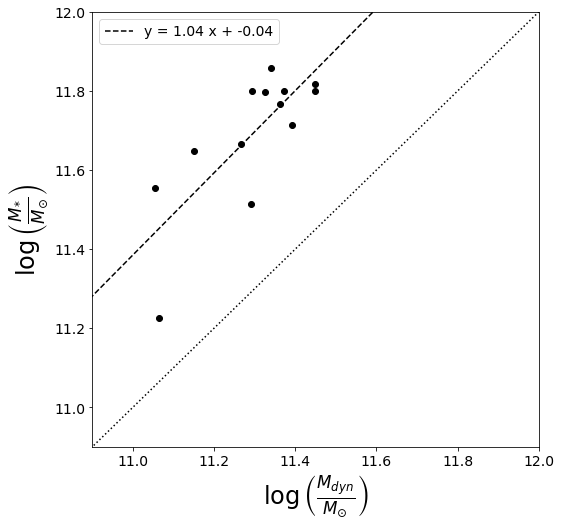

In [100]:
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(log_Mdyn, log_Mstar,
          c='k')
ax.set_ylim(10.9, 12)
ax.set_xlim(10.9, 12)
ax.set_xlabel(r'$\log\left(\frac{M_{dyn}}{M_{\odot}}\right)$', fontsize=24)
ax.set_ylabel(r'$\log\left(\frac{M_{*}}{M_{\odot}}\right)$', fontsize=24)
x = np.linspace(10.7, 12.1, 1000)
y = m * x + b
ax.plot(x, y, c='k', linestyle='--', label=f'y = {"{:.2f}".format(m)} x + {"{:.2f}".format(b)}')
y2 = x
ax.plot(x, y2, c='k', linestyle=':')
ax.legend()

# We also want to look at the mass-size relation and the mass plane (MP, M, sigma, reff_maj)

In [101]:
log_reff_maj = np.log10(reff_majs_kpc.value)
log_slacs_reff = np.log10(reffs_slacs_kpc.value)
log_reff_maj

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log10
  """Entry point for launching an IPython kernel.


array([0.94338851, 0.93380284, 0.89048236, 0.81144831, 0.49174609,
       0.67026203,        nan, 0.87804921, 0.87575891, 0.63263174,
       0.91016047, 0.77573926, 0.73578239, 0.90509906])

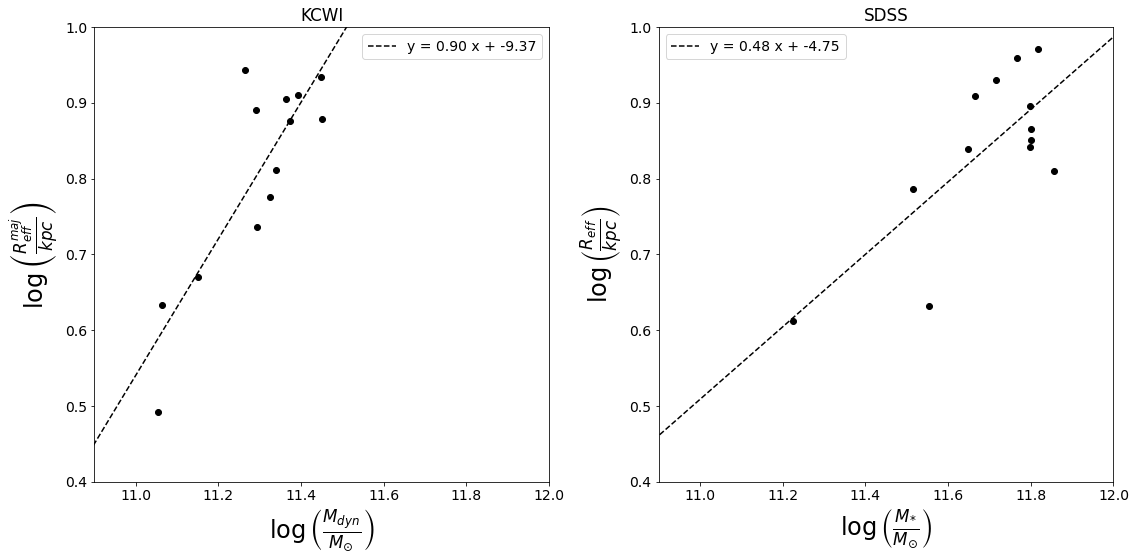

In [102]:
not_na = np.isfinite(log_reff_maj)

m0, b0 = np.polyfit(log_Mdyn[not_na], log_reff_maj[not_na], 1)
m1, b1 = np.polyfit(log_Mstar[not_na], log_slacs_reff[not_na], 1)
x = np.linspace(10.7, 12.1, 1000)
y0 = m0 * x + b0
y1 = m1 * x + b1

fig, ax = plt.subplots(1, 2, figsize=(16,8))

# dynamical mass to reff
ax[0].scatter(log_Mdyn[not_na], log_reff_maj[not_na], 
          c='k')
ax[0].plot(x, y0, 'k--', label=f'y = {"{:.2f}".format(m0)} x + {"{:.2f}".format(b0)}')
ax[0].set_xlim(10.9, 12)
ax[0].set_ylim(0.4, 1.0)
ax[0].set_ylabel(r'$\log\left(\frac{R_{eff}^{maj}}{kpc}\right)$', fontsize=24)
ax[0].set_xlabel(r'$\log\left(\frac{M_{dyn}}{M_{\odot}}\right)$', fontsize=24)
ax[0].legend()
ax[0].set_title('KCWI')

# stellar mass to reff
ax[1].scatter(log_Mstar[not_na], log_slacs_reff[not_na], 
          c='k')
ax[1].plot(x, y1, 'k--', label=f'y = {"{:.2f}".format(m1)} x + {"{:.2f}".format(b1)}')
ax[1].set_xlim(10.9, 12)
ax[1].set_ylim(0.4, 1.0)
#ax[0].set_xlim(10.8, 11.7)
ax[1].set_ylabel(r'$\log\left(\frac{R_{eff}}{kpc}\right)$', fontsize=24)
ax[1].set_xlabel(r'$\log\left(\frac{M_{*}}{M_{\odot}}\right)$', fontsize=24)        
ax[1].legend()
ax[1].set_title('SDSS')
        
#ax[0].legend()
plt.tight_layout()

In [103]:
log_VD = np.log10(classifications.VD_ap_pix)
log_VD_sdss = np.log10(classifications['SLACS VD'])

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


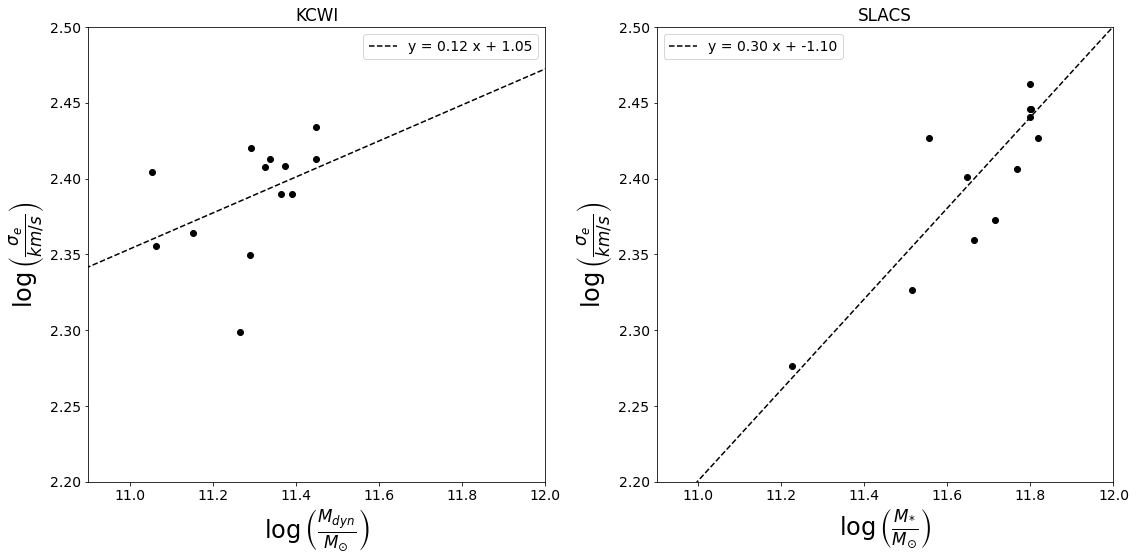

In [104]:
m0, b0 = np.polyfit(log_Mdyn[not_na], log_VD[not_na], 1)
m1, b1 = np.polyfit(log_Mstar[not_na], log_VD_sdss[not_na], 1)
x = np.linspace(10.7, 12.1, 1000)
y0 = m0 * x + b0
y1 = m1 * x + b1

fig, ax = plt.subplots(1, 2, figsize=(16,8))

# dynamical mass to reff
ax[0].scatter(log_Mdyn[not_na], log_VD[not_na], 
          c='k')
ax[0].plot(x, y0, 'k--', label=f'y = {"{:.2f}".format(m0)} x + {"{:.2f}".format(b0)}')
ax[0].set_xlim(10.9, 12)
ax[0].set_ylim(2.2, 2.5)
ax[0].set_ylabel(r'$\log\left(\frac{\sigma_{e}}{km/s}\right)$', fontsize=24)
ax[0].set_xlabel(r'$\log\left(\frac{M_{dyn}}{M_{\odot}}\right)$', fontsize=24)
ax[0].legend()
ax[0].set_title('KCWI')

# stellar mass to reff
ax[1].scatter(log_Mstar[not_na], log_VD_sdss[not_na], 
          c='k')
ax[1].plot(x, y1, 'k--', label=f'y = {"{:.2f}".format(m1)} x + {"{:.2f}".format(b1)}')
ax[1].set_xlim(10.9, 12)
ax[1].set_ylim(2.2, 2.5)
#ax[0].set_xlim(10.8, 11.7)
ax[1].set_ylabel(r'$\log\left(\frac{\sigma_{e}}{km/s}\right)$', fontsize=24)
ax[1].set_xlabel(r'$\log\left(\frac{M_{*}}{M_{\odot}}\right)$', fontsize=24)        
ax[1].legend()
ax[1].set_title('SLACS')
        
#ax[0].legend()
plt.tight_layout()

# Let's look at the mass plane. From virial relation:

# $ \log(\sigma_e) = 1/2 \log(M) - 1/2[log(5 R_e / 2 G)] $

and

# $ \log(R_e) = \log(M) - log(5 \sigma_e^2 / 2 G) $

In [105]:
# calculate lines of constant Re and constant sigma e
# as in Cappellari 2016 review Figure 20

# same values shown in Cap2016 Fig 20
const_sigmas = np.array([#50, # km/s
                       #100,
                       200,
                       300,
                       400,
                       500
                        ]
                      )

const_res = np.array([0.1, # kpc
                    1,
                    10,
                    100]
                   )

# calculate the intercepts as above
const_sigmas_int = - np.log10( 5 * const_sigmas**2 / (2 * G_unit.value))
const_res_int = - 1/2 * np.log10( 5 * const_res / (2 * G_unit.value))

# take range of masses
masses = np.linspace(10.8, 12.0, 100)

# calculate the lines
lines_const_sigmas = np.zeros((len(const_sigmas),len(masses)))
lines_const_res = np.zeros((len(const_res),len(masses)))

for i, intercept in enumerate(const_sigmas_int):
    lines_const_sigmas[i] = masses + intercept
for i, intercept in enumerate(const_res_int):
    lines_const_res[i] = 1/2 * masses + intercept
 

In [106]:
const_sigmas_int

array([-10.36643891, -10.71862143, -10.9684989 , -11.16231893])

In [107]:
from plotbin.sauron_colormap import register_sauron_colormap
register_sauron_colormap()

In [108]:
log_ml_rs[6] = 'NaN'

In [109]:
log_ml_rs

array([0.693, 0.665, 0.487, 0.793, 0.835, 0.548,   nan, 0.706, 0.728,
       0.577, 0.571, 0.83 , 0.671, 0.779])

In [110]:
# take log ml for my models
log_lum = np.log10(classifications.luminosities)
log_ml_kcwi = log_Mdyn - log_lum
log_ml_kcwi

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  


0     0.320353
1     1.452015
2     0.264168
3     0.264798
4     1.520559
5     1.265511
6          NaN
7     1.594619
8     0.312550
9     0.389975
10    1.455935
11    1.671875
12    1.534894
13    1.591101
Name: luminosities, dtype: float64

# Zone of exclusion from Cap 2013a

# $R_e^{maj} = R_{e,b} (M_{JAM}/M_{JAM,b})^{\gamma} [1/2 + 1/2 (M_{JAM}/M_{JAM,b})^{\alpha}]^{(\beta - \gamma)/(\alpha)}$
# $\log(R_e^{maj}) = \log(R_{e,b})  + \gamma \log(M/M_b) + (\beta - \gamma)/\alpha \log(1/2 + 1/2 (M/M_b)^{\alpha}) $
## $R_{e,b} = 0.7$ kpc
## $\alpha = 8$
## $\beta = 0.75 $
## $ \gamma = -0.20$
## $M_b = 3.0 \times 10^{10} M_{\odot} $

In [111]:
reb = 0.7
alpha = 8
beta = 0.75
gamma = -0.20
Mb = 3e10

masses_zoe = np.linspace(10, 12, 100)

zoe = np.log10(reb) + gamma * np.log(10**masses_zoe/Mb) + (beta - gamma)/alpha * np.log10(1/2 + 1/2 * (10**masses_zoe/Mb)**alpha)

mean_beta = 0.57
mean_gamma = 0.12

mean_zoe = np.log10(reb) + mean_gamma * np.log(10**masses_zoe/Mb) + (mean_beta - mean_gamma)/alpha * np.log10(1/2 + 1/2 * (10**masses_zoe/Mb)**alpha)


In [112]:
zoe

array([ 0.02908105,  0.01978121,  0.01048298,  0.00118706, -0.0081055 ,
       -0.01739318, -0.0266738 , -0.03594419, -0.04519973, -0.0544338 ,
       -0.06363678, -0.07279485, -0.08188813, -0.09088822, -0.09975472,
       -0.10843077, -0.11683737, -0.12486678, -0.13237607, -0.13918271,
       -0.14506598, -0.14977884, -0.15307394, -0.15474297, -0.15465954,
       -0.15280964, -0.14929514, -0.14430879, -0.13809264, -0.13089672,
       -0.12294949, -0.11444286, -0.10552885, -0.0963229 , -0.08691015,
       -0.07735213, -0.06769264, -0.05796257, -0.04818354, -0.03837062,
       -0.02853426, -0.01868171, -0.008818  ,  0.00105343,  0.01093017,
        0.02081058,  0.03069351,  0.04057819,  0.05046407,  0.06035078,
        0.07023806,  0.08012573,  0.09001367,  0.0999018 ,  0.10979006,
        0.11967841,  0.12956682,  0.13945527,  0.14934375,  0.15923225,
        0.16912077,  0.17900929,  0.18889782,  0.19878636,  0.20867489,
        0.21856343,  0.22845198,  0.23834052,  0.24822906,  0.25

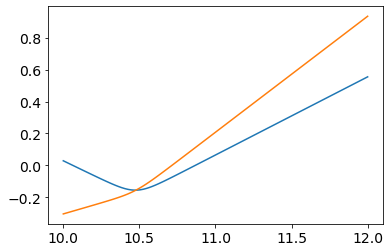

In [113]:
plt.plot(masses_zoe, zoe)
plt.plot(masses_zoe, mean_zoe)

In [114]:
# From Cap2016 review Mcrit 2e11 separates fast and slow
M_crit = np.log10(2e11)

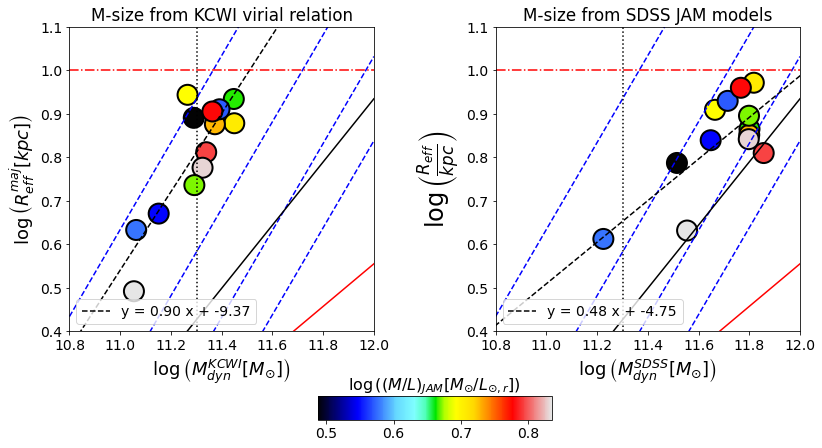

In [115]:
m0, b0 = np.polyfit(log_Mdyn[not_na], log_reff_maj[not_na], 1)
m1, b1 = np.polyfit(log_Mstar[not_na], log_slacs_reff[not_na], 1)
x = np.linspace(10.7, 12.1, 1000)
y0 = m0 * x + b0
y1 = m1 * x + b1

fontsize = 18

fig, ax = plt.subplots(1, 2, figsize=(14,8))#, sharey=True)
#plt.subplots_adjust(wspace=-0.2)

# dynamical mass to reff
p = ax[0].scatter(log_Mdyn[not_na], log_reff_maj[not_na], 
          c=log_ml_rs[not_na], cmap='sauron', s=400, edgecolor='k', linewidth=2)
cb = fig.colorbar(p, location='bottom', orientation='horizontal', ax=ax[:], shrink = 0.3, aspect=10)
cb.ax.set_title(r'$\log\left({(M/L)_{JAM}}[M_{\odot}/L_{\odot,r}]\right)$', fontsize=fontsize-2)
ax[0].plot(x, y0, 'k--', label=f'y = {"{:.2f}".format(m0)} x + {"{:.2f}".format(b0)}')  
# plot lines of constant sigma and reff
for line in lines_const_sigmas:
    ax[0].plot(masses, line, 'b--')
    ax[1].plot(masses, line, 'b--')
for re in const_res:
   ax[0].axhline(np.log10(re), 0, 1, c='r', linestyle='-.')
   ax[1].axhline(np.log10(re), 0, 1, c='r', linestyle='-.')
# plot zoe
ax[0].plot(masses_zoe, zoe, 'r')
ax[1].plot(masses_zoe, zoe, 'r')
# plot mean zoe
ax[0].plot(masses_zoe, mean_zoe, 'k')
ax[1].plot(masses_zoe, mean_zoe, 'k')
# plot mcrit
ax[0].axvline(M_crit, 0, 1, c='k', linestyle=':')
ax[1].axvline(M_crit, 0, 1, c='k', linestyle=':')
ax[0].set_xlim(10.8, 12)
ax[0].set_ylim(0.4, 1.1)
ax[0].set_ylabel(r'$\log\left(R_{eff}^{maj} [kpc]\right)$', fontsize=fontsize)
ax[0].set_xlabel(r'$\log\left(M_{dyn}^{KCWI} [{M_{\odot}}]\right)$', fontsize=fontsize)
ax[0].set_box_aspect(1)
ax[0].legend(loc='lower left')
ax[0].set_title(r'M-size from KCWI virial relation')

# stellar mass to reff
ax[1].scatter(log_Mstar[not_na], log_slacs_reff[not_na], 
          c=log_ml_rs[not_na], cmap='sauron', s=400, edgecolor='k', linewidth=2)
ax[1].plot(x, y1, 'k--', label=f'y = {"{:.2f}".format(m1)} x + {"{:.2f}".format(b1)}')
ax[1].set_xlim(10.8, 12)
ax[1].set_ylim(0.4, 1.1)
#ax[0].set_xlim(10.8, 11.7)
ax[1].set_ylabel(r'$\log\left(\frac{R_{eff}}{kpc}\right)$', fontsize=24)
ax[1].set_xlabel(r'$\log\left(M_{dyn}^{SDSS}[M_{\odot}]\right)$', fontsize=fontsize)  
ax[1].set_box_aspect(1)
ax[1].legend(loc='lower left')
ax[1].set_title('M-size from SDSS JAM models')
        
#ax[0].legend()
#plt.tight_layout()
plt.savefig(f'{data_dir}mass_size_{date}.pdf', bbox_inches='tight')
plt.savefig(f'{data_dir}mass_size_{date}.png', bbox_inches='tight')

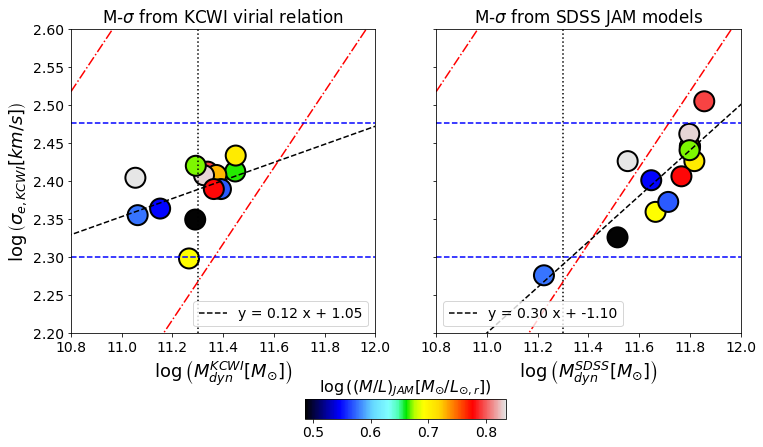

In [116]:
m0, b0 = np.polyfit(log_Mdyn[not_na], log_VD[not_na], 1)
m1, b1 = np.polyfit(log_Mstar[not_na], log_VD_sdss[not_na], 1)
x = np.linspace(10.5, 12.1, 1000)
y0 = m0 * x + b0
y1 = m1 * x + b1

fontsize = 18

fig, ax = plt.subplots(1, 2, figsize=(12,8), sharey=True)
#plt.subplots_adjust(wspace=-0.2)

# dynamical mass to sigma
p = ax[0].scatter(log_Mdyn[not_na], log_VD[not_na], 
          c=log_ml_rs[not_na], cmap='sauron', s=400, edgecolor='k', linewidth=2)
cb = fig.colorbar(p, location='bottom', orientation='horizontal', ax=ax[:], shrink = 0.3, aspect=10)
cb.ax.set_title(r'$\log\left({(M/L)_{JAM}}[M_{\odot}/L_{\odot,r}]\right)$', fontsize=fontsize-2)
ax[0].plot(x, y0, 'k--', label=f'y = {"{:.2f}".format(m0)} x + {"{:.2f}".format(b0)}')
for line in lines_const_res:
    ax[0].plot(masses, line, 'r-.')
    ax[1].plot(masses, line, 'r-.')
for sigma in const_sigmas:
   ax[0].axhline(np.log10(sigma), 0, 1, c='b', linestyle='--')
   ax[1].axhline(np.log10(sigma), 0, 1, c='b', linestyle='--')
# plot mcrit
ax[0].axvline(M_crit, 0, 1, c='k', linestyle=':')
ax[1].axvline(M_crit, 0, 1, c='k', linestyle=':')
ax[0].set_xlim(10.8, 12)
ax[0].set_ylim(2.2, 2.6)
ax[0].set_ylabel(r'$\log\left(\sigma_{e,KCWI}[km/s]\right)$', fontsize=fontsize)
ax[0].set_xlabel(r'$\log\left(M_{dyn}^{KCWI} [{M_{\odot}}]\right)$', fontsize=fontsize)
ax[0].set_box_aspect(1)
ax[0].legend()
ax[0].set_title(r'M-$\sigma$ from KCWI virial relation')

# stellar mass to reff
ax[1].scatter(log_Mstar[not_na], log_VD_sdss[not_na], 
          c=log_ml_rs[not_na], cmap='sauron', s=400, edgecolor='k', linewidth=2)
ax[1].plot(x, y1, 'k--', label=f'y = {"{:.2f}".format(m1)} x + {"{:.2f}".format(b1)}')
ax[1].set_xlim(10.8, 12)
ax[1].set_ylim(2.2, 2.6)
#ax[0].set_xlim(10.8, 11.7)
#ax[1].set_ylabel(r'$\log\left(\frac{\sigma_{e}}{km/s}\right)$', fontsize=fontsize)
ax[1].set_xlabel(r'$\log\left(M_{dyn}^{SDSS}[M_{\odot}]\right)$', fontsize=fontsize)      
ax[1].set_box_aspect(1)
ax[1].legend(loc='lower left')
ax[1].set_title(r'M-$\sigma$ from SDSS JAM models')
        
#ax[0].legend()
#plt.tight_layout()
plt.savefig(f'{data_dir}mass_sigma_{date}.pdf', bbox_inches='tight')
plt.savefig(f'{data_dir}mass_sigma_{date}.png', bbox_inches='tight')

# Let's look to see if there is a split in the classification


In [117]:
colors = np.array(['r','b','k','g'])
#class_colors=np.zeros(len(obj_names), '<U14')
#for i in range(len(obj_names)):
#    class_num = classes_num[i]
    #class_colors[i] = colors[class_num]

In [155]:
not_na

array([ True,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True,  True,  True,  True])

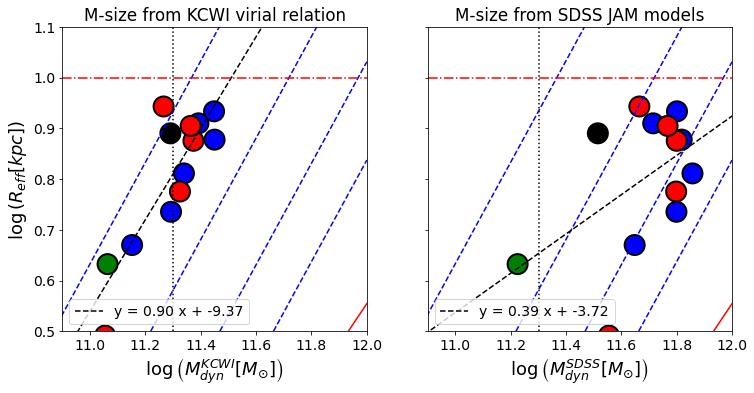

In [160]:
m0, b0 = np.polyfit(log_Mdyn[not_na], log_reff_maj[not_na], 1)
m1, b1 = np.polyfit(log_Mstar[not_na], log_reff_maj[not_na], 1)
x = np.linspace(10.7, 12.1, 1000)
y0 = m0 * x + b0
y1 = m1 * x + b1

fontsize = 18

fig, ax = plt.subplots(1, 2, figsize=(12,8), sharey=True)
#plt.subplots_adjust(wspace=-0.2)

# dynamical mass to reff
p = ax[0].scatter(log_Mdyn[not_na], log_reff_maj[not_na], 
          c=colors[classes_num][not_na], cmap='sauron', s=400, edgecolor='k', linewidth=2)
#cb = fig.colorbar(p, location='bottom', orientation='horizontal', ax=ax[:], shrink = 0.3, aspect=10)
#cb.ax.set_title(r'$\log\left({(M_{dyn}^{SDSS}/L)_{dyn}}[M_{\odot}/L_{\odot,r}]\right)$', fontsize=fontsize-2)
ax[0].plot(x, y0, 'k--', label=f'y = {"{:.2f}".format(m0)} x + {"{:.2f}".format(b0)}')  
# plot lines of constant sigma and reff
for line in lines_const_sigmas:
    ax[0].plot(masses, line, 'b--')
    ax[1].plot(masses, line, 'b--')
for re in const_res:
   ax[0].axhline(np.log10(re), 0, 1, c='r', linestyle='-.')
   ax[1].axhline(np.log10(re), 0, 1, c='r', linestyle='-.')
# plot zoe
ax[0].plot(masses, zoe, 'r')
ax[1].plot(masses, zoe, 'r')
# plot mcrit
ax[0].axvline(M_crit, 0, 1, c='k', linestyle=':')
ax[1].axvline(M_crit, 0, 1, c='k', linestyle=':')
ax[0].set_xlim(10.9, 12)
ax[0].set_ylim(0.5, 1.1)
ax[0].set_ylabel(r'$\log\left(R_{eff} [kpc]\right)$', fontsize=fontsize)
ax[0].set_xlabel(r'$\log\left(M_{dyn}^{KCWI} [{M_{\odot}}]\right)$', fontsize=fontsize)
ax[0].set_box_aspect(1)
ax[0].legend(loc='lower left')
ax[0].set_title(r'M-size from KCWI virial relation')

# stellar mass to reff
ax[1].scatter(log_Mstar[not_na], log_reff_maj[not_na], 
          c=colors[classes_num][not_na], cmap='sauron', s=400, edgecolor='k', linewidth=2)
ax[1].plot(x, y1, 'k--', label=f'y = {"{:.2f}".format(m1)} x + {"{:.2f}".format(b1)}')
ax[1].set_xlim(10.9, 12)
ax[1].set_ylim(0.5, 1.1)
#ax[0].set_xlim(10.8, 11.7)
#ax[1].set_ylabel(r'$\log\left(\frac{R_{eff}}{kpc}\right)$', fontsize=24)
ax[1].set_xlabel(r'$\log\left(M_{dyn}^{SDSS}[M_{\odot}]\right)$', fontsize=fontsize)  
ax[1].set_box_aspect(1)
ax[1].legend(loc='lower left')
ax[1].set_title('M-size from SDSS JAM models')
        
#ax[0].legend()
#plt.tight_layout()
plt.savefig(f'{data_dir}mass_size_classes_{date}.pdf', bbox_inches='tight')
plt.savefig(f'{data_dir}mass_size_classes_{date}.png', bbox_inches='tight')

# Look at aperture effects by integrating velocities at a range of aperture radii.
# 1/4 reff, 1/2 reff, 3/4 reff, 1 reff, 1.25, 1.5 etc


In [161]:
# plug in the extra steps of doing the integral over luminosity weighted pixels instead of just the bins. Will be more spatially accurate as an aperture of radius reff

reff_factors = np.array([0.25,
                     0.5,
                     0.75,
                     1.0,
                     1.25,
                     1.5])

V_sigmas_bin_method_aptest = np.zeros((len(reff_factors), len(obj_names)))
lambda_Rs_bin_method_aptest = np.zeros((len(reff_factors), len(obj_names)))
V_ap_int_rms_bin_method_aptest = np.zeros((len(reff_factors), len(obj_names)))
VD_ap_int_rms_bin_method_aptest = np.zeros((len(reff_factors), len(obj_names)))
dV_ap_int_rms_bin_method_aptest = np.zeros((len(reff_factors), len(obj_names)))
dVD_ap_int_rms_bin_method_aptest = np.zeros((len(reff_factors), len(obj_names)))

V_sigmas_pixel_method_aptest = np.zeros((len(reff_factors), len(obj_names)))
lambda_Rs_pixel_method_aptest = np.zeros((len(reff_factors), len(obj_names)))
V_ap_int_rms_pixel_method_aptest = np.zeros((len(reff_factors), len(obj_names)))
VD_ap_int_rms_pixel_method_aptest = np.zeros((len(reff_factors), len(obj_names)))
dV_ap_int_rms_pixel_method_aptest = np.zeros((len(reff_factors), len(obj_names)))
dVD_ap_int_rms_pixel_method_aptest = np.zeros((len(reff_factors), len(obj_names)))


for i, obj_name in enumerate(obj_names):
    
    print('Object ' + obj_name)
    #################
    # set up directories
    obj_abbr = obj_name[4:9] # e.g. J0029
    # data directory
    data_dir = '/data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/'
    # object directory
    dir = f'{data_dir}mosaics/{obj_name}/'
    #KCWI mosaic datacube
    name = f'KCWI_{obj_abbr}_icubes_mosaic_0.1457'
    save_dir = f'{dir}{obj_name}_systematics/'

    #################
    # get velocity and bin data 
    VD=np.genfromtxt(f'{dir}{obj_name}_final_kinematics/{obj_name}_VD_binned.txt',
             delimiter=',')
    VD_cov = np.genfromtxt(f'{dir}{obj_name}_final_kinematics/{obj_name}_covariance_matrix_VD.txt',
                     delimiter=',')
    dVD = np.sqrt(np.diagonal(VD_cov))
    V=np.genfromtxt(f'{dir}{obj_name}_final_kinematics/{obj_name}_V_binned.txt',
                     delimiter=',')
    # subtract the mean V
    V = V - np.mean(V)
    V_cov = np.genfromtxt(f'{dir}{obj_name}_final_kinematics/{obj_name}_covariance_matrix_V.txt',
                     delimiter=',')
    dV = np.sqrt(np.diagonal(V_cov))
    
    # import voronoi binning data (#bins, 5215), spectrum for each bin
    voronoi_binning_data = fits.getdata(dir +'voronoi_binning_' + name + '_data.fits')
    num_bins = len(voronoi_binning_data)
    # import pixel data for bins
    vorbin_pixels = np.genfromtxt(f'{dir}voronoi_2d_binning_{name}_output.txt',
                 delimiter='')
    
    #################
    # sum each bin across all wavelengths to get bin luminosities
    bin_luminosities = np.zeros(len(V))
    for j in range(len(V)):
        lum = np.sum(voronoi_binning_data[j])
        bin_luminosities[j] = lum
        

    #################
    # get mean R for each bin by pixel positions
    short_name = obj_name[4:]
    R = calc_R (vorbin_pixels, len(V))
    print(f'length before cutting... {len(R)}')
    if i==6:
        effective_radius = slacs_reffs[i]
    else:
        effective_radius = reffs[i]
    for k, factor in enumerate(reff_factors):
        print('factor ', factor)
        condition = R < factor*effective_radius
        R_in_aperture = R[condition]
        V_in_aperture = V[condition]
        VD_in_aperture = VD[condition]
        dV_in_aperture = dV[condition]
        dVD_in_aperture = dVD[condition]
        bin_luminosities_in_aperture = bin_luminosities[condition]
        print(f'length after cutting... {len(R_in_aperture)}')
        #print()

        #################
        # calculate V_sigma
        V_sigmas_bin_method_aptest[k,i], V_ap_int_rms_bin_method_aptest[k,i], \
            VD_ap_int_rms_bin_method_aptest[k,i], dV_ap_int_rms_bin_method_aptest[k,i], \
                dVD_ap_int_rms_bin_method_aptest[k,i] = lum_weight_V_sigma ( V_in_aperture, VD_in_aperture, 
                                                                            dV_in_aperture, dVD_in_aperture, 
                                                                            bin_luminosities_in_aperture )
        # calculate lambda_R
        lambda_Rs_bin_method_aptest[k,i] = calc_lambda_R (V_in_aperture, VD_in_aperture, R_in_aperture, bin_luminosities_in_aperture)

        ###########################################
        # Now second method
        ###########################################

        # bring in cropped datacube and sum across wavelengths
        file = f'{dir}KCWI_{obj_abbr}_icubes_mosaic_0.1457_crop.fits'
        datacube = fits.open(file)[0].data
        summed_datacube = np.nansum(datacube, axis=0)
        normalized_summed_datacube = summed_datacube/np.sum(summed_datacube)

        # get effective radius
        #if obj_name == 'SDSSJ1306+0600':
        #    reff = 2.30
        #else:    
            # get reff from slacs table
        #    slacs_table = np.genfromtxt(f'{data_dir}slacs_tableA1.txt', delimiter='', dtype='U10')
        #    slacs_table_name = obj_name[4:]
        #    slacs_reffs = slacs_table[:,7].astype(float)
        #    reff = slacs_reffs[slacs_table[:,0]==slacs_table_name]


        # calculate pixel luminosities
        pixel_luminosities = np.zeros(len(vorbin_pixels))
        for j in range(len(vorbin_pixels)):
            x = int(vorbin_pixels[j,0])
            y = int(vorbin_pixels[j,1])
            pixel_luminosity = summed_datacube[y,x]
            pixel_luminosities[j] = pixel_luminosity

        # calculate luminosity weights for each bin contribution to the integrated velocities within the effective radius
        shells=[1.]
        luminosity_weights = calc_luminosity_weights_in_shells(vorbin_pixels, 
                                                               num_bins, 
                                                               bin_luminosities, 
                                                               pixel_luminosities, 
                                                               shells, 
                                                               factor*effective_radius)

        # calculate the luminosity-weighted mean V and VD for the aperture within the effective radius
        sum_lum_weights = np.sum(luminosity_weights, axis=0) # sum over the weights for the normalization
        normalized_lum_weights = luminosity_weights / sum_lum_weights

        # calculate V_sigma# calculate lambda_R
        V_sigmas_pixel_method_aptest[k,i], \
            lambda_Rs_pixel_method_aptest[k,i], \
            V_ap_int_rms_pixel_method_aptest[k,i], \
            VD_ap_int_rms_pixel_method_aptest[k,i], \
            dV_ap_int_rms_pixel_method_aptest[k,i], \
            dVD_ap_int_rms_pixel_method_aptest[k,i]  = calc_aperture_velocities_from_lum_weight_pixels(vorbin_pixels, 
                                                                                                         V, VD, dV, dVD, 
                                                                                                         pixel_luminosities, 
                                                                                                         factor*effective_radius)

    



Object SDSSJ0029-0055
length before cutting... 193
factor  0.25
length after cutting... 44
factor  0.5
length after cutting... 125
factor  0.75
length after cutting... 169
factor  1.0
length after cutting... 186
factor  1.25
length after cutting... 193


/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in sqrt
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in sqrt
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:138: RuntimeWarning: invalid value encountered in true_divide


factor  1.5
length after cutting... 193
Object SDSSJ0037-0942
length before cutting... 303
factor  0.25
length after cutting... 45
factor  0.5
length after cutting... 163
factor  0.75
length after cutting... 244
factor  1.0
length after cutting... 280
factor  1.25
length after cutting... 299
factor  1.5
length after cutting... 303
Object SDSSJ0330-0020
length before cutting... 12
factor  0.25
length after cutting... 1
factor  0.5
length after cutting... 3
factor  0.75
length after cutting... 6
factor  1.0
length after cutting... 8
factor  1.25
length after cutting... 12
factor  1.5
length after cutting... 12
Object SDSSJ1112+0826
length before cutting... 18
factor  0.25
length after cutting... 2
factor  0.5
length after cutting... 8
factor  0.75
length after cutting... 10
factor  1.0
length after cutting... 15
factor  1.25
length after cutting... 18
factor  1.5
length after cutting... 18
Object SDSSJ1204+0358
length before cutting... 99
factor  0.25
length after cutting... 9
factor  0.

In [162]:
VD_ap_int_rms_pixel_method_aptest.shape

(6, 14)

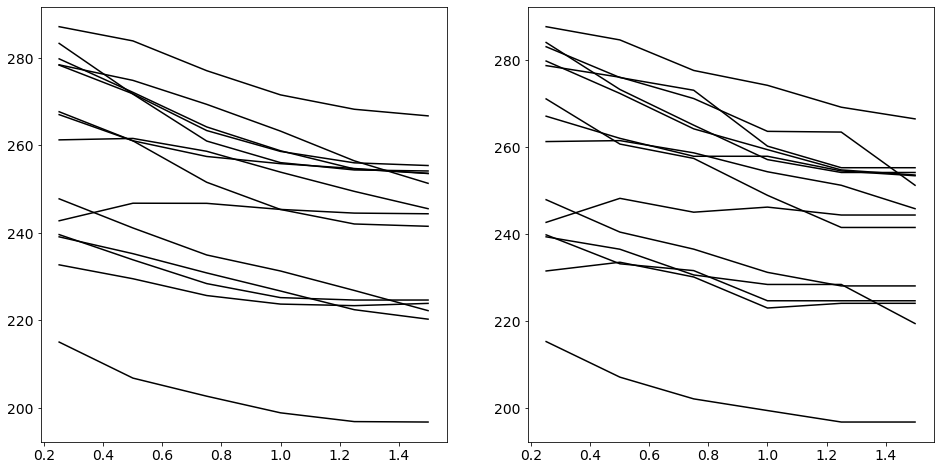

In [163]:
# plot
fig, axs = plt.subplots(1,2, figsize=(16,8))
for i in range(len(obj_names)):
    axs[0].plot(reff_factors, VD_ap_int_rms_pixel_method_aptest[:,i], c='k')
    axs[1].plot(reff_factors, VD_ap_int_rms_bin_method_aptest[:,i], c='k')

In [164]:
reffs

0     2.135808
1     2.154388
2     1.314216
3     1.305929
4     1.038714
5     1.196016
6    -1.000000
7     1.895980
8     2.181738
9     1.494048
10    1.771849
11    1.583747
12    1.213994
13    2.375190
Name: effective_radius, dtype: float64

In [165]:
sdss_sigmas

array([229., 279., 212., 320., 267., 252.,   0., 267., 279., 189., 236.,
       290., 276., 255.])

(170.0, 350.0)

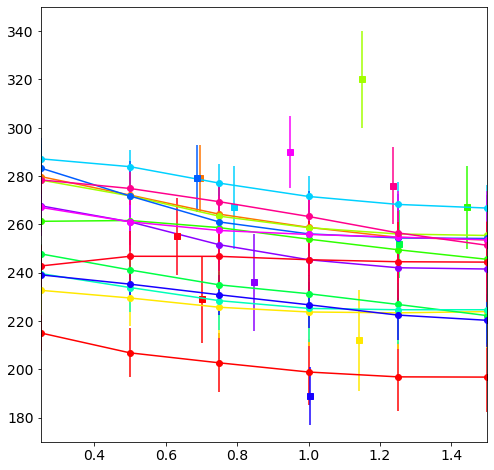

In [174]:
# calculate the SDSS aperture radius divided by the effective radius, plot SDSS sigma there
def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

cmap = get_cmap(14)

aperture_ratios = 1.5/reffs

# plot
fig, ax = plt.subplots(1, figsize=(8,8))
for i in range(len(obj_names)):
    ax.errorbar(reff_factors, 
                VD_ap_int_rms_pixel_method_aptest[:,i], 
                yerr=dVD_ap_int_rms_pixel_method_aptest[:,i], 
                c=cmap(i),
               marker='o',)
    #axs[1].plot(reff_factors, VD_ap_int_rms_bin_method_aptest[:,i], c='k')
    
    ax.errorbar(aperture_ratios[i], 
                sdss_sigmas[i], 
                yerr=sdss_sigmas_err[i], 
                c=cmap(i),
               marker='s')
ax.set_xlim(0.25,1.5)    
ax.set_ylim(170, 350)

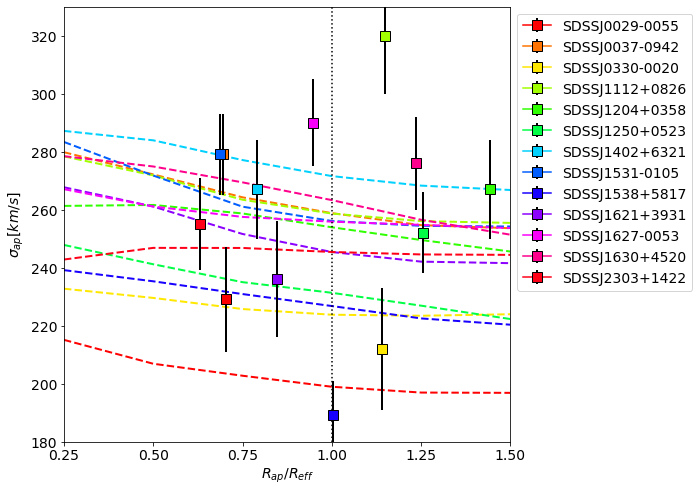

In [167]:
# calculate the SDSS aperture radius divided by the effective radius, plot SDSS sigma there
def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

cmap = get_cmap(14)

aperture_ratios = 1.5/reffs

# plot
fig, ax = plt.subplots(1, figsize=(8,8))
for i in range(len(obj_names)):
    if i==6:
        continue
    ax.plot(reff_factors, 
                VD_ap_int_rms_pixel_method_aptest[:,i], 
                #yerr=dVD_ap_int_rms_pixel_method_aptest[:,i], 
                color=cmap(i),
               marker='',
            markersize=10,
            linestyle='--',
           linewidth=2,
           zorder=-1)
    #axs[1].plot(reff_factors, VD_ap_int_rms_bin_method_aptest[:,i], c='k')
    
    ax.errorbar(aperture_ratios[i], 
                sdss_sigmas[i], 
                yerr=sdss_sigmas_err[i], 
                color=cmap(i),
               marker='s',
              markersize=10,
              markeredgecolor='k',
               elinewidth=2,
                ecolor='k',
                label=obj_names[i]
               )
ax.axvline(1.00, 0, 1, c='k', linestyle=':')
ax.set_xticks(reff_factors)
ax.set_ylim(180, 330)
ax.set_xlim(0.25, 1.5)
ax.set_xlabel(r'$R_{ap}/R_{eff}$')
ax.set_ylabel(r'$\sigma_{ap} [km/s]$')
ax.legend(bbox_to_anchor=(1.0,1.0))

plt.savefig(f'{data_dir}aperture_integration_effects_{date}.pdf')

# Some people think there is a $\sigma/\sigma_e = (r/r_e)^{-0.09}$ relation.

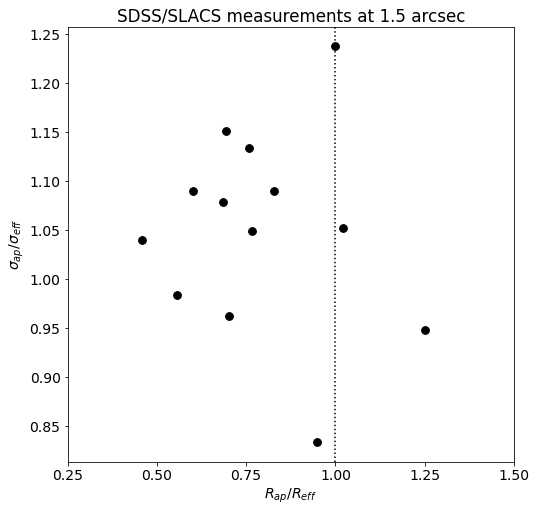

In [220]:
# calculate the SDSS aperture radius divided by the effective radius, plot SDSS sigma there
def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

cmap = get_cmap(14)

aperture_ratios = 1.5/slacs_reffs
sigma_ratios = sdss_sigmas/VD_aperture

# plot
fig, ax = plt.subplots(1, figsize=(8,8))
for i in range(len(obj_names)):
    if i==6:
        continue
    ax.scatter(aperture_ratios[i], sigma_ratios[i], c='k', s=60)
ax.axvline(1.00, 0, 1, c='k', linestyle=':')
ax.set_xticks(reff_factors)
#ax.set_ylim(180, 330)
ax.set_xlim(0.25, 1.5)
ax.set_xlabel(r'$R_{ap}/R_{eff}$')
ax.set_ylabel(r'$\sigma_{ap}/\sigma_{eff}$')
ax.set_title('SDSS/SLACS measurements at 1.5 arcsec')

plt.savefig(f'{data_dir}sigma_ratio_radius_ratio_integration_effects_slacs_measurements_{date}.pdf')

# I see no correlation.
________________________________________
# Integrate the velocity maps over the 1.5arcsec SDSS aperture size to compare.

In [169]:
# plug in the extra steps of doing the integral over luminosity weighted pixels instead of just the bins. Will be more spatially accurate as an aperture of radius reff

aperture_size = 1.5 # arcsec

V_sigmas_bin_method_sdssap = np.zeros((len(obj_names)))
lambda_Rs_bin_method_sdssap = np.zeros((len(obj_names)))
V_ap_int_rms_bin_method_sdssap = np.zeros((len(obj_names)))
VD_ap_int_rms_bin_method_sdssap = np.zeros((len(obj_names)))
dV_ap_int_rms_bin_method_sdssap = np.zeros((len(obj_names)))
dVD_ap_int_rms_bin_method_sdssap = np.zeros((len(obj_names)))

V_sigmas_pixel_method_sdssap = np.zeros((len(obj_names)))
lambda_Rs_pixel_method_sdssap = np.zeros((len(obj_names)))
V_ap_int_rms_pixel_method_sdssap = np.zeros((len(obj_names)))
VD_ap_int_rms_pixel_method_sdssap = np.zeros((len(obj_names)))
dV_ap_int_rms_pixel_method_sdssap = np.zeros((len(obj_names)))
dVD_ap_int_rms_pixel_method_sdssap = np.zeros((len(obj_names)))


for i, obj_name in enumerate(obj_names):
    
    print('Object ' + obj_name)
    #################
    # set up directories
    obj_abbr = obj_name[4:9] # e.g. J0029
    # data directory
    data_dir = '/data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/'
    # object directory
    dir = f'{data_dir}mosaics/{obj_name}/'
    #KCWI mosaic datacube
    name = f'KCWI_{obj_abbr}_icubes_mosaic_0.1457'
    save_dir = f'{dir}{obj_name}_systematics/'

    #################
    # get velocity and bin data 
    VD=np.genfromtxt(f'{dir}{obj_name}_final_kinematics/{obj_name}_VD_binned.txt',
             delimiter=',')
    VD_cov = np.genfromtxt(f'{dir}{obj_name}_final_kinematics/{obj_name}_covariance_matrix_VD.txt',
                     delimiter=',')
    dVD = np.sqrt(np.diagonal(VD_cov))
    V=np.genfromtxt(f'{dir}{obj_name}_final_kinematics/{obj_name}_V_binned.txt',
                     delimiter=',')
    # subtract the mean V
    V = V - np.mean(V)
    V_cov = np.genfromtxt(f'{dir}{obj_name}_final_kinematics/{obj_name}_covariance_matrix_V.txt',
                     delimiter=',')
    dV = np.sqrt(np.diagonal(V_cov))
    
    # import voronoi binning data (#bins, 5215), spectrum for each bin
    voronoi_binning_data = fits.getdata(dir +'voronoi_binning_' + name + '_data.fits')
    num_bins = len(voronoi_binning_data)
    # import pixel data for bins
    vorbin_pixels = np.genfromtxt(f'{dir}voronoi_2d_binning_{name}_output.txt',
                 delimiter='')
    
    #################
    # sum each bin across all wavelengths to get bin luminosities
    bin_luminosities = np.zeros(len(V))
    for j in range(len(V)):
        lum = np.sum(voronoi_binning_data[j])
        bin_luminosities[j] = lum
        

    #################
    # get mean R for each bin by pixel positions
    short_name = obj_name[4:]
    R = calc_R (vorbin_pixels, len(V))
    print(f'length before cutting... {len(R)}')
    if i==6:
        effective_radius = slacs_reffs[i]
    else:
        effective_radius = reffs[i]
    condition = R < aperture_size# factor*effective_radius
    R_in_aperture = R[condition]
    V_in_aperture = V[condition]
    VD_in_aperture = VD[condition]
    dV_in_aperture = dV[condition]
    dVD_in_aperture = dVD[condition]
    bin_luminosities_in_aperture = bin_luminosities[condition]
    print(f'length after cutting... {len(R_in_aperture)}')
    #print()

    #################
    # calculate V_sigma
    V_sigmas_bin_method_sdssap[i], V_ap_int_rms_bin_method_sdssap[i], \
        VD_ap_int_rms_bin_method_sdssap[i], dV_ap_int_rms_bin_method_sdssap[i], \
            dVD_ap_int_rms_bin_method_sdssap[i] = lum_weight_V_sigma ( V_in_aperture, VD_in_aperture, 
                                                                        dV_in_aperture, dVD_in_aperture, 
                                                                        bin_luminosities_in_aperture )
    # calculate lambda_R
    lambda_Rs_bin_method_sdssap[i] = calc_lambda_R (V_in_aperture, VD_in_aperture, R_in_aperture, bin_luminosities_in_aperture)

    ###########################################
    # Now second method
    ###########################################

    # bring in cropped datacube and sum across wavelengths
    file = f'{dir}KCWI_{obj_abbr}_icubes_mosaic_0.1457_crop.fits'
    datacube = fits.open(file)[0].data
    summed_datacube = np.nansum(datacube, axis=0)
    normalized_summed_datacube = summed_datacube/np.sum(summed_datacube)

    # get effective radius
    #if obj_name == 'SDSSJ1306+0600':
    #    reff = 2.30
    #else:    
        # get reff from slacs table
    #    slacs_table = np.genfromtxt(f'{data_dir}slacs_tableA1.txt', delimiter='', dtype='U10')
    #    slacs_table_name = obj_name[4:]
    #    slacs_reffs = slacs_table[:,7].astype(float)
    #    reff = slacs_reffs[slacs_table[:,0]==slacs_table_name]


    # calculate pixel luminosities
    pixel_luminosities = np.zeros(len(vorbin_pixels))
    for j in range(len(vorbin_pixels)):
        x = int(vorbin_pixels[j,0])
        y = int(vorbin_pixels[j,1])
        pixel_luminosity = summed_datacube[y,x]
        pixel_luminosities[j] = pixel_luminosity

    # calculate luminosity weights for each bin contribution to the integrated velocities within the effective radius
    shells=[1.]
    luminosity_weights = calc_luminosity_weights_in_shells(vorbin_pixels, 
                                                           num_bins, 
                                                           bin_luminosities, 
                                                           pixel_luminosities, 
                                                           shells, 
                                                           aperture_size)

    # calculate the luminosity-weighted mean V and VD for the aperture within the effective radius
    sum_lum_weights = np.sum(luminosity_weights, axis=0) # sum over the weights for the normalization
    normalized_lum_weights = luminosity_weights / sum_lum_weights

    # calculate V_sigma# calculate lambda_R
    V_sigmas_pixel_method_sdssap[i], \
        lambda_Rs_pixel_method_sdssap[i], \
        V_ap_int_rms_pixel_method_sdssap[i], \
        VD_ap_int_rms_pixel_method_sdssap[i], \
        dV_ap_int_rms_pixel_method_sdssap[i], \
        dVD_ap_int_rms_pixel_method_sdssap[i]  = calc_aperture_velocities_from_lum_weight_pixels(vorbin_pixels, 
                                                                                                     V, VD, dV, dVD, 
                                                                                                     pixel_luminosities, 
                                                                                                     aperture_size)





Object SDSSJ0029-0055
length before cutting... 193
length after cutting... 162
Object SDSSJ0037-0942
length before cutting... 303
length after cutting... 228
Object SDSSJ0330-0020
length before cutting... 12
length after cutting... 11
Object SDSSJ1112+0826
length before cutting... 18
length after cutting... 18
Object SDSSJ1204+0358
length before cutting... 99
length after cutting... 85
Object SDSSJ1250+0523
length before cutting... 65
length after cutting... 53
Object SDSSJ1306+0600
length before cutting... 64
length after cutting... 51
Object SDSSJ1402+6321
length before cutting... 108
length after cutting... 91
Object SDSSJ1531-0105
length before cutting... 39
length after cutting... 28
Object SDSSJ1538+5817
length before cutting... 45
length after cutting... 34
Object SDSSJ1621+3931
length before cutting... 37
length after cutting... 30
Object SDSSJ1627-0053
length before cutting... 71
length after cutting... 58
Object SDSSJ1630+4520
length before cutting... 52
length after cutting.

In [170]:
# also show the 1/2 Reff measurement
VD_half_reff = VD_ap_int_rms_pixel_method_aptest[1,:]
dVD_half_reff = dVD_ap_int_rms_pixel_method_aptest[1,:]
VD_half_reff

array([206.81755664, 272.12873766, 229.5251568 , 271.78442577,
       261.59220204, 241.12986654, 233.85407544, 283.87852217,
       271.72285397, 235.25679194, 261.04176839, 261.05403666,
       274.8581915 , 246.7866112 ])

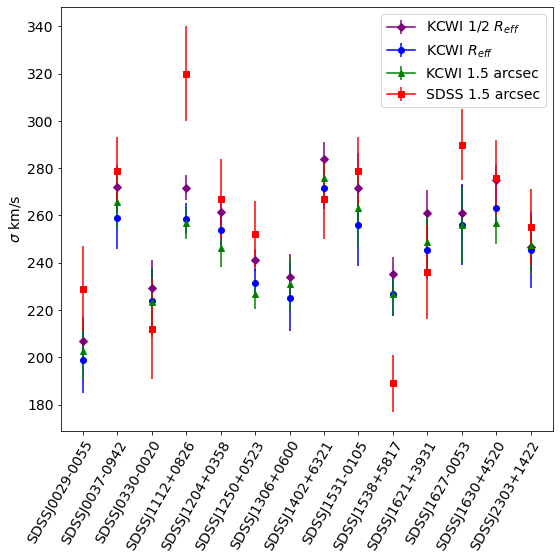

In [171]:
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(8,8))
for i in range(14):
    plt.errorbar(i, VD_half_reff[i], yerr=dVD_half_reff[i], c='purple', marker='D')
    plt.errorbar(i, VD_ap_int_rms_pixel_method[i], yerr=dVD_ap_int_rms_pixel_method[i], c='b', marker='o')
    plt.errorbar(i, VD_ap_int_rms_pixel_method_sdssap[i], yerr=dVD_ap_int_rms_pixel_method_sdssap[i], c='g', marker='^')
    if i==6:
        continue
    plt.errorbar(i, sdss_sigmas[i], yerr=sdss_sigmas_err[i], c='r', marker='s')
    if i==0:
        plt.legend([r'KCWI 1/2 $R_{eff}$', 'KCWI $R_{eff}$', r'KCWI 1.5 arcsec', 'SDSS 1.5 arcsec'], bbox_to_anchor=(1.0,1.0))
plt.xticks(range(14), labels=obj_names, rotation=60, ha='right', rotation_mode='anchor')
plt.ylabel(r'$\sigma$ km/s')
plt.tight_layout()
plt.savefig(f'{data_dir}aperture_integrated_velocity_dispersions_{date}.pdf')

In [172]:
date

'020723'

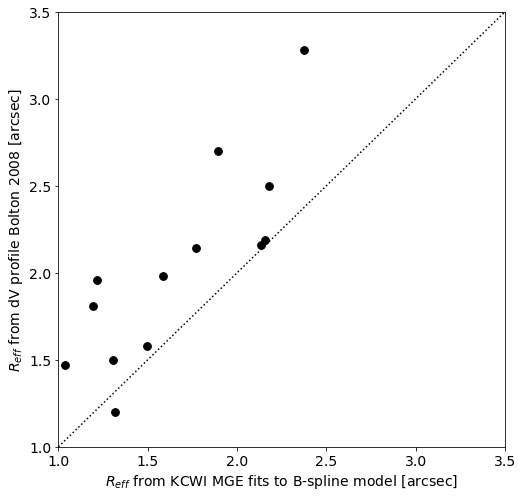

In [185]:
x = np.linspace(1,3.5, 100)
y = x

fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(reffs, slacs_reffs, c='k', s=60)
ax.set_xlim(1, 3.5)
ax.set_ylim(1, 3.5)
ax.set_ylabel(r'$R_{eff}$ from dV profile Bolton 2008 [arcsec]')
ax.set_xlabel(r'$R_{eff}$ from KCWI MGE fits to B-spline model [arcsec]')
ax.plot(x, y, 'k:')


In [196]:
np.mean((reffs[not_na]-slacs_reffs[not_na])/slacs_reffs[not_na])

-0.1694150477670577

In [ ]:
# Effective radii are on average 17% smaller for my measurements

# Look at the velocity dispersions

In [197]:
np.mean((VD_aperture[not_na]-sdss_sigmas[not_na])/sdss_sigmas[not_na])

-0.03842000763376426

In [195]:
# My KCWI integrated velocity dispersions are on average 4% smaller

array([229., 279., 212., 320., 267., 252.,   0., 267., 279., 189., 236.,
       290., 276., 255.])

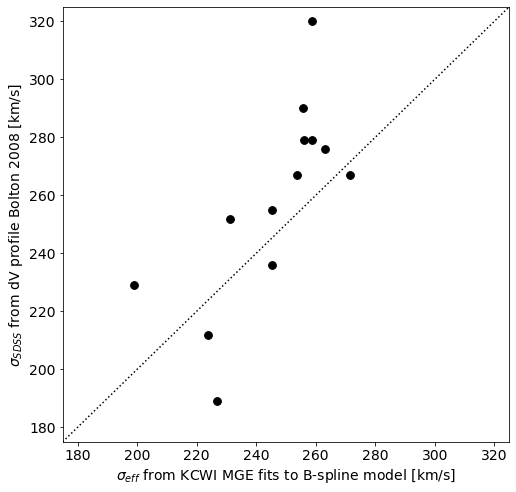

In [202]:
x = np.linspace(175,325, 100)
y = x

fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(VD_aperture[not_na], sdss_sigmas[not_na], c='k', s=60)
ax.set_xlim(175,325)
ax.set_ylim(175,325)
ax.set_ylabel(r'$\sigma_{SDSS}$ from dV profile Bolton 2008 [km/s]')
ax.set_xlabel(r'$\sigma_{eff}$ from KCWI MGE fits to B-spline model [km/s]')
ax.plot(x, y, 'k:')


In [203]:
# What about integrated within the 1.5'' aperture???

In [205]:
np.mean((VD_ap_int_rms_pixel_method_sdssap[not_na]-sdss_sigmas[not_na])/sdss_sigmas[not_na])

-0.03610684656590503

# Let's do the ratio test again, this time with my values at 1.5''

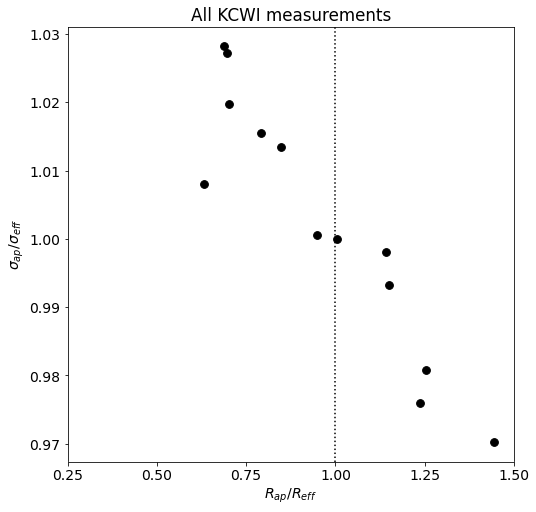

In [212]:
# calculate the SDSS aperture radius divided by the effective radius, plot SDSS sigma there
def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

cmap = get_cmap(14)

aperture_ratios = 1.5/reffs
sigma_ratios = VD_ap_int_rms_pixel_method_sdssap/VD_aperture

# plot
fig, ax = plt.subplots(1, figsize=(8,8))
for i in range(len(obj_names)):
    if i==6:
        continue
    ax.scatter(aperture_ratios[i], sigma_ratios[i], c='k', s=60)
ax.axvline(1.00, 0, 1, c='k', linestyle=':')
ax.set_xticks(reff_factors)
#ax.set_ylim(180, 330)
ax.set_xlim(0.25, 1.5)
ax.set_xlabel(r'$R_{ap}/R_{eff}$')
ax.set_ylabel(r'$\sigma_{ap}/\sigma_{eff}$')
ax.set_title('All KCWI measurements')

plt.savefig(f'{data_dir}sigma_ratio_radius_ratio_integration_effects_kcwi_measurements_{date}.pdf')

In [213]:
# Oh shit there's a really clear linear relation there!

-0.06665541125096756 1.066646099646352


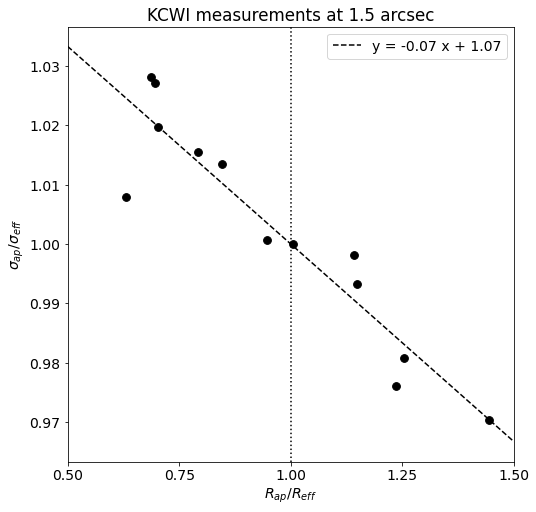

In [219]:
# linear fit
m, b = np.polyfit(aperture_ratios[not_na], sigma_ratios[not_na], deg=1)
print(m, b)

# calculate the SDSS aperture radius divided by the effective radius, plot SDSS sigma there
def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

cmap = get_cmap(14)

aperture_ratios = 1.5/reffs
sigma_ratios = VD_ap_int_rms_pixel_method_sdssap/VD_aperture

# plot
fig, ax = plt.subplots(1, figsize=(8,8))
for i in range(len(obj_names)):
    if i==6:
        continue
    ax.scatter(aperture_ratios[i], sigma_ratios[i], c='k', s=60)
ax.axvline(1.00, 0, 1, c='k', linestyle=':')

# plot the linear relation
xx = np.linspace(0.5, 1.5)
yy = m*xx+b
ax.plot(xx, yy, c='k', linestyle='--', label=f'y = {"{:.2f}".format(m)} x + {"{:.2f}".format(b)}')
ax.set_xticks(reff_factors)
#ax.set_ylim(180, 330)
ax.set_xlim(0.5, 1.5)
ax.set_xlabel(r'$R_{ap}/R_{eff}$')
ax.set_ylabel(r'$\sigma_{ap}/\sigma_{eff}$')
ax.set_title('KCWI measurements at 1.5 arcsec')
ax.legend()

plt.savefig(f'{data_dir}sigma_ratio_radius_ratio_integration_effects_kcwi_measurements_{date}.pdf')

# Wait... this is for an individual aperture size... which is convenient in describing one cross-section of the rainbow diagram above.
# But check out Cappellari 2006 for how he got the power law relation with power -0.066 https://arxiv.org/pdf/astro-ph/0505042.pdf
# Look at aperture effects by integrating velocities at a larger range of aperture radii.
# 0.1 to 1.5 Reff in steps of 0.1
# Do only the pixel method.

In [439]:
# plug in the extra steps of doing the integral over luminosity weighted pixels instead of just the bins. Will be more spatially accurate as an aperture of radius reff

reff_factors = np.arange(0.1, 1.6, 0.1)#np.array([0.25,
               #      0.5,
               #      0.75,
               #      1.0,
               #      1.25,
               #      1.5])


V_sigmas_pixel_method_aptest2 = np.zeros((len(reff_factors), len(obj_names)))
lambda_Rs_pixel_method_aptest2 = np.zeros((len(reff_factors), len(obj_names)))
V_ap_int_rms_pixel_method_aptest2 = np.zeros((len(reff_factors), len(obj_names)))
VD_ap_int_rms_pixel_method_aptest2 = np.zeros((len(reff_factors), len(obj_names)))
dV_ap_int_rms_pixel_method_aptest2 = np.zeros((len(reff_factors), len(obj_names)))
dVD_ap_int_rms_pixel_method_aptest2 = np.zeros((len(reff_factors), len(obj_names)))


for i, obj_name in enumerate(obj_names):
    
    print('Object ' + obj_name)
    #################
    # set up directories
    obj_abbr = obj_name[4:9] # e.g. J0029
    # data directory
    data_dir = '/data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/'
    # object directory
    dir = f'{data_dir}mosaics/{obj_name}/'
    #KCWI mosaic datacube
    name = f'KCWI_{obj_abbr}_icubes_mosaic_0.1457'
    save_dir = f'{dir}{obj_name}_systematics/'

    #################
    # get velocity and bin data 
    VD=np.genfromtxt(f'{dir}{obj_name}_final_kinematics/{obj_name}_VD_binned.txt',
             delimiter=',')
    VD_cov = np.genfromtxt(f'{dir}{obj_name}_final_kinematics/{obj_name}_covariance_matrix_VD.txt',
                     delimiter=',')
    dVD = np.sqrt(np.diagonal(VD_cov))
    V=np.genfromtxt(f'{dir}{obj_name}_final_kinematics/{obj_name}_V_binned.txt',
                     delimiter=',')
    # subtract the mean V
    V = V - np.mean(V)
    V_cov = np.genfromtxt(f'{dir}{obj_name}_final_kinematics/{obj_name}_covariance_matrix_V.txt',
                     delimiter=',')
    dV = np.sqrt(np.diagonal(V_cov))
    
    # import voronoi binning data (#bins, 5215), spectrum for each bin
    voronoi_binning_data = fits.getdata(dir +'voronoi_binning_' + name + '_data.fits')
    num_bins = len(voronoi_binning_data)
    # import pixel data for bins
    vorbin_pixels = np.genfromtxt(f'{dir}voronoi_2d_binning_{name}_output.txt',
                 delimiter='')
    
    #################
    # sum each bin across all wavelengths to get bin luminosities
    bin_luminosities = np.zeros(len(V))
    for j in range(len(V)):
        lum = np.sum(voronoi_binning_data[j])
        bin_luminosities[j] = lum
        
       
    # bring in cropped datacube and sum across wavelengths
    file = f'{dir}KCWI_{obj_abbr}_icubes_mosaic_0.1457_crop.fits'
    datacube = fits.open(file)[0].data
    summed_datacube = np.nansum(datacube, axis=0)
    normalized_summed_datacube = summed_datacube/np.sum(summed_datacube)


    # calculate pixel luminosities
    pixel_luminosities = np.zeros(len(vorbin_pixels))
    for j in range(len(vorbin_pixels)):
        x = int(vorbin_pixels[j,0])
        y = int(vorbin_pixels[j,1])
        pixel_luminosity = summed_datacube[y,x]
        pixel_luminosities[j] = pixel_luminosity
        
    #################
    # get mean R for each bin by pixel positions
    short_name = obj_name[4:]
    R = calc_R (vorbin_pixels, len(V))
    #print(f'length before cutting... {len(R)}')
    if i==6:
        effective_radius = slacs_reffs[i]
    else:
        effective_radius = reffs[i]

    # loop through the different apertures    
    for k, factor in enumerate(reff_factors):
        # calculate luminosity weights for each bin contribution to the integrated velocities within the effective radius
        shells=[1.]
        luminosity_weights = calc_luminosity_weights_in_shells(vorbin_pixels, 
                                                               num_bins, 
                                                               bin_luminosities, 
                                                               pixel_luminosities, 
                                                               shells, 
                                                               factor*effective_radius)

        # calculate the luminosity-weighted mean V and VD for the aperture within the effective radius
        sum_lum_weights = np.sum(luminosity_weights, axis=0) # sum over the weights for the normalization
        normalized_lum_weights = luminosity_weights / sum_lum_weights

        # calculate V_sigma# calculate lambda_R
        V_sigmas_pixel_method_aptest2[k,i], \
            lambda_Rs_pixel_method_aptest2[k,i], \
            V_ap_int_rms_pixel_method_aptest2[k,i], \
            VD_ap_int_rms_pixel_method_aptest2[k,i], \
            dV_ap_int_rms_pixel_method_aptest2[k,i], \
            dVD_ap_int_rms_pixel_method_aptest2[k,i]  = calc_aperture_velocities_from_lum_weight_pixels(vorbin_pixels, 
                                                                                                         V, VD, dV, dVD, 
                                                                                                         pixel_luminosities, 
                                                                                                         factor*effective_radius)

    



Object SDSSJ0029-0055


/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in sqrt
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in sqrt
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:101: RuntimeWarning: invalid value encountered in true_divide


Object SDSSJ0037-0942
Object SDSSJ0330-0020
Object SDSSJ1112+0826


/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars


Object SDSSJ1204+0358
Object SDSSJ1250+0523
Object SDSSJ1306+0600
Object SDSSJ1402+6321
Object SDSSJ1531-0105
Object SDSSJ1538+5817
Object SDSSJ1621+3931
Object SDSSJ1627-0053
Object SDSSJ1630+4520
Object SDSSJ2303+1422


In [440]:
VD_ap_int_rms_pixel_method_aptest2.shape

(15, 14)

In [441]:
# take the ratio of each velocity dispersion to the one at the effective radius
VD_ratio = VD_ap_int_rms_pixel_method_aptest2 / VD_ap_int_rms_pixel_method_aptest2[9]
dVD_ratio = VD_ratio * np.sqrt((dVD_ap_int_rms_pixel_method_aptest2/VD_ap_int_rms_pixel_method_aptest2)**2 \
                               + (dVD_ap_int_rms_pixel_method_aptest2[9]/VD_ap_int_rms_pixel_method_aptest2[9])**2)
# take the effective radius factors as the x axis

In [442]:
p = np.polyfit(reff_factors, VD_ratio[:,0], w=1/dVD_ratio[:,0], deg=1, cov=True)
p

(array([-0.07061287,  1.07952756]), array([[ 5.08610369e-05, -3.74406851e-05],
        [-3.74406851e-05,  3.72746888e-05]]))

mean p0, mean p1,  -0.037505948144143694 0.00046001682256130487
merr, berr 0.014824889987510937 0.005005846960026756


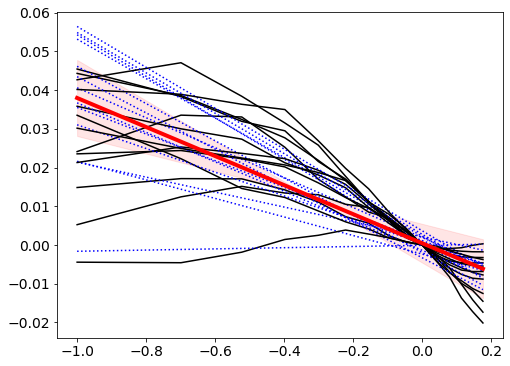

In [443]:
# plot

logx = np.log10(reff_factors)
logy = np.log10(VD_ratio[:,not_na])
dlogy = dVD_ratio[:,not_na]/VD_ratio[:,not_na]

p0s = np.zeros(13)
p1s = np.zeros(13)
variances = np.zeros((13, 2))

fig, axs = plt.subplots(figsize=(8,6))
for i in range(13):
    p, cov = np.polyfit(logx, logy[:,i], w=dlogy[:,i], deg=1, cov=True)
    p0s[i] = p[0]
    p1s[i] = p[1]
    variances[i] = np.diag(cov)
    fit = p[0]*logx + p[1]
    axs.plot(logx, logy[:,i], c='k')
    axs.plot(logx, fit, c='b', linestyle=':')
   # axs[1].plot(reff_factors, VD_ap_int_rms_bin_method_aptest2[:,i], c='k')

m = np.mean(p0s)
b = np.mean(p1s)
merr = np.sqrt(np.sum(variances[:,0]))
berr = np.sqrt(np.sum(variances[:,1]))

yfit = m*logx+b
yfit_err_low = (m-merr)*logx+(b-berr)
yfit_err_hi = (m+merr)*logx+(b+berr)

print('mean p0, mean p1, ', m, b)
print('merr, berr', merr, berr)
plt.plot(logx, yfit, 'r', linewidth=4)
plt.fill_between(logx, yfit_err_low, yfit_err_hi, color='r', alpha=0.1)



In [444]:
m

-0.037505948144143694

In [445]:
"{:.4f}".format(m)

'-0.0375'

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_to_inches" which is no longer supported as of 3.3 and will become an error in 3.6
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_to_inches" which is no longer supported as of 3.3 and will become an error in 3.6


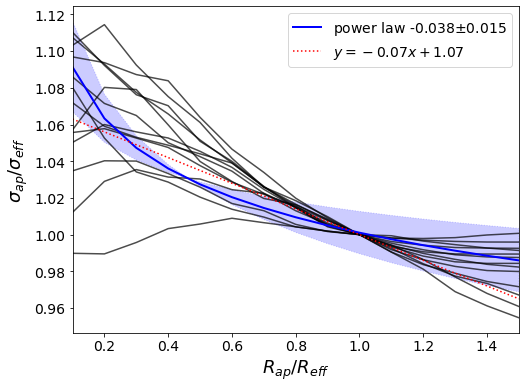

In [474]:
# plot

fig, axs = plt.subplots(figsize=(8,6))
for i in range(13):
    axs.plot(reff_factors, VD_ratio[:,not_na][:,i], c='k', alpha=0.7)

fit = reff_factors**m * 10**b
fit_err_lo = reff_factors**(m-merr)*10**(b-berr)
fit_err_hi = reff_factors**(m+merr)*10**(b+berr)
    
# now do the fit
axs.plot(reff_factors, fit, c='b', linestyle='-', linewidth=2,
        label=f'power law {"{:.3f}".format(m)}$\pm${"{:.3f}".format(merr)}')
axs.fill_between(reff_factors, fit_err_lo, fit_err_hi, color='b', linestyle=':', alpha=0.2)
#axs.plot(reff_factors, fit_err_hi, c='b', linestyle=':')
         
# plot the linear correlation for aperture of 1.5 arcseconds
axs.plot(reff_factors, -0.07*reff_factors+1.07, 
        color='r',
        linestyle=':',
        label=r'$y = -0.07 x + 1.07$',
        )
    
   # axs[1].plot(reff_factors, VD_ap_int_rms_bin_method_aptest2[:,i], c='k')
axs.set_xlim(0.1,1.5)
axs.set_xlabel(r'$R_{ap}/R_{eff}$', fontsize=18)
axs.set_ylabel(r'$\sigma_{ap}/\sigma_{eff}$', fontsize=18)
axs.legend()

plt.savefig(f'{data_dir}aperture_correction_power_law.png', bbox_to_inches='tight')
plt.savefig(f'{data_dir}aperture_correction_power_law.pdf', bbox_to_inches='tight')

In [456]:
# What is the difference between the curve and the line from 0.6 to 1.5?
(10**b*0.6**m - (-0.07*0.6+1.07))#/(10**b*0.6**m)

-0.0075759999625120145

In [460]:
np.abs(10**b*0.6**m-(-0.07*0.6+1.07))/(10**b*0.6**m)

0.0074243647368483

In [461]:
np.abs(10**b*1.5**m-(-0.07*1.5+1.07))/(10**b*1.5**m)

0.02125002008905744

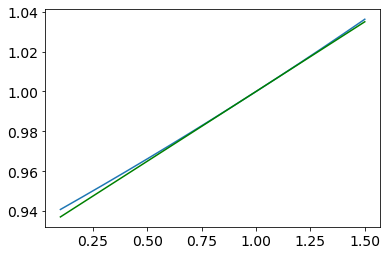

In [466]:
fig, axs = plt.subplots()
axs.plot(reff_factors, 1/(1+0.07*(1-reff_factors)))
axs.plot(reff_factors, 1-0.07*(1-reff_factors),
         color='g')


In [472]:
np.abs(1/(1+0.07*(1-reff_factors))-(1-0.07*(1-reff_factors)))/(1/(1+0.07*(1-reff_factors)))

array([3.969e-03, 3.136e-03, 2.401e-03, 1.764e-03, 1.225e-03, 7.840e-04,
       4.410e-04, 1.960e-04, 4.900e-05, 0.000e+00, 4.900e-05, 1.960e-04,
       4.410e-04, 7.840e-04, 1.225e-03])

In [363]:
np.array(obj_names)[not_na]

array(['SDSSJ0029-0055', 'SDSSJ0037-0942', 'SDSSJ0330-0020',
       'SDSSJ1112+0826', 'SDSSJ1204+0358', 'SDSSJ1250+0523',
       'SDSSJ1402+6321', 'SDSSJ1531-0105', 'SDSSJ1538+5817',
       'SDSSJ1621+3931', 'SDSSJ1627-0053', 'SDSSJ1630+4520',
       'SDSSJ2303+1422'], dtype='<U14')

KeyError: 6

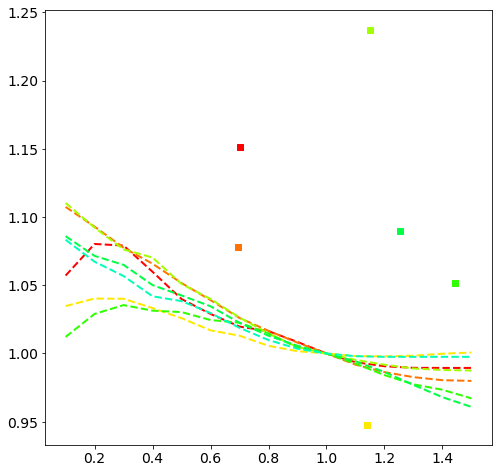

In [383]:
# put it in the rainbow plot format!
def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

cmap = get_cmap(14)

aperture_ratios = 1.5/reffs[not_na]

# plot
fig, ax = plt.subplots(1, figsize=(8,8))
for i in range(len(np.array(obj_names)[not_na])):
    ax.plot(reff_factors, 
                VD_ratio[:,i], 
                #yerr=dVD_ap_int_rms_pixel_method_aptest[:,i], 
                color=cmap(i),
               marker='',
            markersize=10,
            linestyle='--',
           linewidth=2,
           zorder=-1)
    #axs[1].plot(reff_factors, VD_ap_int_rms_bin_method_aptest[:,i], c='k')
    
    ax.scatter(aperture_ratios[i], 
                sdss_sigmas[not_na][i]/VD_ap_int_rms_pixel_method_aptest2[9][not_na][i], 
                #yerr=sdss_sigmas_err[not_na][i]/VD_ap_int_rms_pixel_method_aptest2[not_na][9], 
                color=cmap(i),
               marker='s',
              #markersize=10,
              #markeredgecolor='k',
               #elinewidth=2,
               # ecolor='k',
                label=np.array(obj_names)[not_na]
               )
ax.axvline(1.00, 0, 1, c='k', linestyle=':')
ax.set_xticks(reff_factors)
ax.set_ylim(180, 330)
ax.set_xlim(0.25, 1.5)
ax.set_xlabel(r'$R_{ap}/R_{eff}$')
ax.set_ylabel(r'$\sigma_{ap} [km/s]$')
ax.legend(bbox_to_anchor=(1.0,1.0))

#plt.savefig(f'{data_dir}aperture_integration_effects_{date}.pdf')

In [374]:
VD_ap_int_rms_pixel_method_aptest2[9][not_na]

array([198.88419488, 258.77054803, 223.73219216, 258.62386902,
       253.889966  , 231.29472948, 271.54384472, 256.06120459,
       226.72524022, 245.35660125, 255.82366329, 263.2631181 ,
       245.36817177])

In [377]:
np.array(obj_names)[not_na]

array(['SDSSJ0029-0055', 'SDSSJ0037-0942', 'SDSSJ0330-0020',
       'SDSSJ1112+0826', 'SDSSJ1204+0358', 'SDSSJ1250+0523',
       'SDSSJ1402+6321', 'SDSSJ1531-0105', 'SDSSJ1538+5817',
       'SDSSJ1621+3931', 'SDSSJ1627-0053', 'SDSSJ1630+4520',
       'SDSSJ2303+1422'], dtype='<U14')

In [378]:
aperture_ratios.size

13

In [381]:
sdss_sigmas[not_na].size

13